In [1]:
import numpy as np
import pandas as pd
import matplotlib
print(matplotlib.__version__)
matplotlib.use('PDF')
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.lines as mlines
from glob import glob
from collections import Counter
import re, os
import history_cmc as hic
import math
import scipy
from scipy.interpolate import interp1d
from scipy import stats
import matplotlib.cm as cm
import matplotlib as mpl
import random
from random import shuffle
import gzip
import sys
import astropy as ap
from astropy import units
from scipy.optimize import bisect
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


import gw_ecc_calc as gwcalc
import unit_convert as uc
import merger_rate_calculator as mr
import ns_tidalcapture_hdf5 as tc
import conversions
import dynamics as dyn
import scripts3
import scripts2
import scripts1
import scripts
import LISA_calculations as lisa_calc
import extract_full_hist as ehist
import psr_catalog as pc
import ns, ns_hdf5


sys.path.insert(1, '/projects/b1095/syr904/MyCodes/cmctoolkit')
import cmctoolkit as cmct

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

matplotlib.rcParams.update({'font.size': 22})
#from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
#rc('font',**{'family':'serif','serif':['Times']})
#plt.rcParams['font.family'] = 'serif'
#plt.rcParams['font.serif'] = 'Times New Roman'
#plt.rc('font', family='serif')
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
      
twopi=2.*np.pi
yearsc=3.1557*10**7
Kconst=9.87*10**-48 ##yr/G^2
Gconst=6.674*10**-8 ##cm3*g-1*s-2
Gconst_sun = 4.30091*10**-3 ##pc*M_sun**-1*(km/s)2
clight=3*10**10 ##cm/s
Msun=2*10**33 ##gram
Rsun=6.957e+10 ##cm
AU=1.496*10**13  ##cm
AU_Rsun=214.93946938362 ##AU to R_sun
PC=3.086*10**18  ##cm
PC_Rsun = 44334448.0068964 ##pc to R_sun

savepath = '/projects/b1095/syr904/projects/mass_gap_bhs/'

2.1.2


In [2]:
sourcedir = np.genfromtxt('/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc6752/paths_delay_rapid.dat',
                         dtype=str)
model_type = sourcedir[:,2]
print(model_type)
paths = np.array(list(sourcedir[:,0][::3])+list(sourcedir[:,0][1::3])+list(sourcedir[:,0][2::3]))

snap_h5 = 'initial.snapshots.h5'

delay_sep = 6
ab_cut = 6

print(paths)


###return bh snapshot names
def bh_snaps(sourcedir):
    bhsnap_h5 = 'initial.blackhole.snapshots.h5'
    
    with pd.HDFStore(sourcedir+bhsnap_h5) as bhsnap_hdf:
        bhsnap_keys = np.sort(bhsnap_hdf.keys())  
        
    t_conv = dyn.conv('t', sourcedir+'initial.conv.sh')
    
    def read_keys(thekey):
        return re.findall(r'\d+\.\d+|\d+', thekey)
    
    bh_snaptime = []; bh_floattime = []
    for ii in range(len(bhsnap_keys)):
        thetime = read_keys(bhsnap_keys[ii])[0]
        bh_snaptime.append(thetime)
        bh_floattime.append(float(thetime))
    
    ind = np.argsort(bh_floattime)
    bh_floattime_sort = np.array(bh_floattime)[ind]
    bh_snaptime_sort = np.array(bh_snaptime)[ind]
    
    return bh_floattime_sort, bh_snaptime_sort

['1' '1' '1' '3' '3' '3' '2' '2' '2' '4' '4' '4']
['/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc6752/allfixed/n8-rv0.5-rg8-z0.0002_iccatalog_alloff_cotdeoff_rerun/'
 '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc6752/allfixed/n8-rv0.5-rg8-z0.0002_iccatalog_alloff_cotdeoff_rerun_delay/'
 '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc6752/allfixed/n8-rv0.5-rg8-z0.0002_iccatalog_alloff_cotdeoff_wdmass/'
 '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc6752/allfixed/n8-rv0.5-rg8-z0.0002_iccatalog_alloff_cotdeoff_wdmass_delay/'
 '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc6752/allfixed/n8-rv0.5-rg8-z0.0002_iccatalog_nstde0.2_wdtc_rerun/'
 '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc6752/allfixed/n8-rv0.5-rg8-z0.0002_iccatalog_nstde0.2_wdtc_rerun_

13021.5
13033.6
13097.3
12909.9
13134.6
13010.1
13177.2
12901.0
13148.0
12914.4
13037.5
13076.9


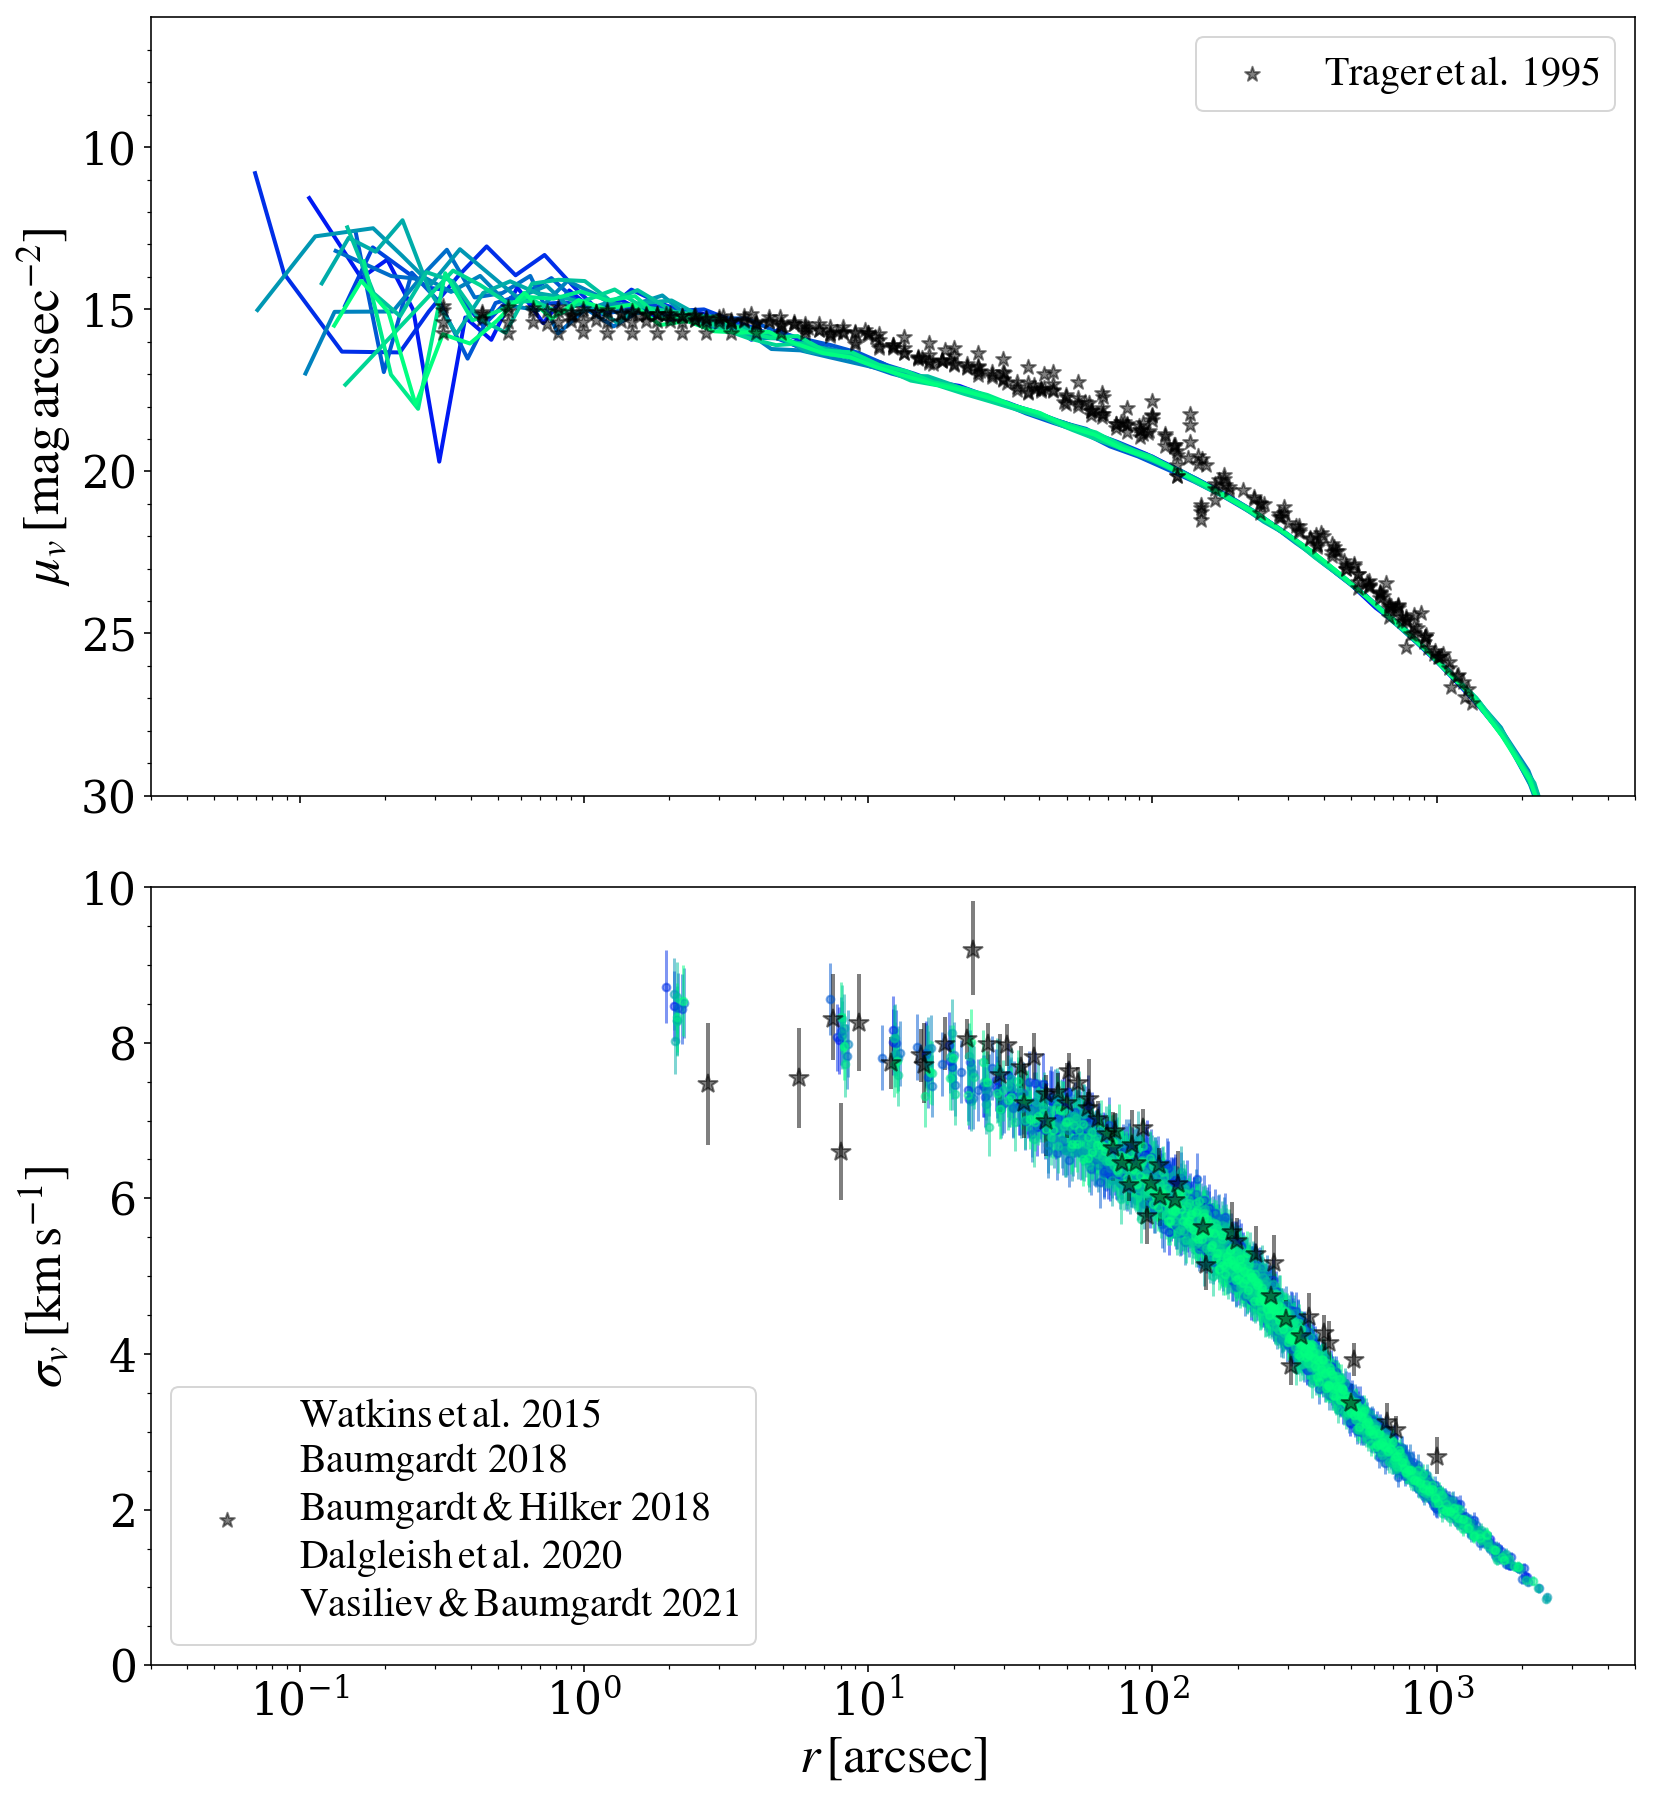

In [6]:
##Surface brightness and velocity dispersion profiles
###Observations###
R_sun_obs=4.125
ngcno='6752'

ft = open('makeSBP/trager.dat','r')
linest = ft.readlines()

fv = open('makeSBP/vel_dispersion_profiles_GEDR3.dat','r')
linesv = fv.readlines()

flag = 0
#### find observed SBP from trager file
arcsec_t = []
SB_t = []
for k in range(len(linest)):
    linet = linest[k]
    linet = linet.split('\n')
    linet = linet[0]
    linet = linet.split('\t')
    cluster_tregar = linet[1]
    if cluster_tregar == 'ngc'+ngcno:
        arcsec_t.append(np.float(linet[2]))
        SB_t.append(np.float(linet[3]))
        flag = 1
arcsec_t = np.array(arcsec_t[:])
SB_t = np.array(SB_t[:])
if flag == 0:
        print('Trager doesnt have the SBP or sigma v profile')
        sys.exit()

flag = 0
#### find observed sigma_v profile
datav = np.genfromtxt('makeSBP/vel_dispersion_profiles_GEDR3.dat')
R_obs = [] # in arcsec
sigma_obs = []
sigma_err_obs_up = []
sigma_err_obs_down = []
for k in range(len(linesv)):
    linev = linesv[k]
    linev = linev.split('\n')
    linev = linev[0]
    linev = linev.split(' ')
    cluster_sigma = linev[0]
    if cluster_sigma == 'NGC'+ngcno:
        R_obs.append(datav[k,1])
        sigma_obs.append(datav[k,2])
        sigma_err_obs_up.append(datav[k,3])
        sigma_err_obs_down.append(datav[k,4])
        flag = 1
R_obs = np.array(R_obs[:])
sigma_obs = np.array(sigma_obs[:])
sigma_err_obs_up = np.array(sigma_err_obs_up[:])
sigma_err_obs_down = np.array(sigma_err_obs_down[:])
############
if flag == 0:
        print('No observed sigmav profile')
        sys.exit()
        

fig, ax=plt.subplots(2, 1, sharex=True,  figsize=(12,13))
#ax[0].set_title(r'$\rm{NGC}\ $'+ngcno, fontsize=20)
ax[0].scatter(10**arcsec_t[:], SB_t[:], facecolor='k', marker = '*', 
              alpha=0.5, s=60, label=r'$\rm{Trager\,et\,al.\,1995}$', zorder=3)
ax[1].errorbar(R_obs,sigma_obs,yerr=[sigma_err_obs_down,sigma_err_obs_up], fmt='*', 
               markersize = 10, alpha=0.5, c='k', lw=2.0)
ax[1].scatter([10000,10000], [-5,-5], c='k', marker = '*', alpha=0.5, s=60,
              label=r'$\rm{Watkins\,et\,al.\,2015}$' '\n'
              r'$\rm{Baumgardt\,\,2018}$' '\n'
              r'$\rm{Baumgardt\,&\,Hilker\,\,2018}$' '\n'
              r'$\rm{Dalgleish\,et\,al.\,2020}$' '\n'
              r'$\rm{Vasiliev\,&\,Baumgardt\,\,2021}$')
             
cs = cm.winter(np.linspace(0.1, 1, 12))
###Models###
for xx in range(len(paths)):
    snap2D = np.sort(glob(paths[xx]+'initial.snap*.2Dproj.dat.gz'))
    snap2D_L12 = np.sort(glob(paths[xx]+'initial.snap*.2D_SBPLcut12_NCUT-1.dat'))
    snap_vel700 = np.sort(glob(paths[xx]+'initial.snap*.vel_dispersion_vr_pm_700_0.dat'))

    for ii in range(0, len(snap2D_L12)):
        with open(snap2D_L12[ii], 'r') as f2D:
            first_line=f2D.readline()

        t_gyr = float(first_line.strip().split('=')[-1])
        if t_gyr>=12900.:
            print(t_gyr)
            data5 = np.genfromtxt(snap2D_L12[ii])
            arcsec = conversions.pc_to_arcsec(data5[:,1],R_sun_obs)
            SB = conversions.SB_converter(data5[:,3])
            SBerr = data5[:,6]/data5[:,5]*SB
            
            arcsec_cut = []
            SB_cut = []
            SBerr_cut = []
            for k in range(len(SB)):
                if arcsec[k] < 10 and SB[k] > 20:
                    Nothing = 0
                else:
                    arcsec_cut.append(arcsec[k])
                    SB_cut.append(SB[k])
                    #SBerr_cut.append(SBerr[k])
        
            datavel = np.genfromtxt(snap_vel700[ii])
            R_model = conversions.pc_to_arcsec(datavel[:,0],R_sun_obs)
            sigma_model = datavel[:,1]
            sigma_err_model = datavel[:,2]
        
            ax[0].plot(arcsec_cut, SB_cut, lw=2, color=cs[xx])
            ax[0].plot([10000,10000],[-5,-5], lw=2, color=cs[xx])
            ax[1].scatter(R_model[::3], sigma_model[::3],s=15,zorder=2,alpha=0.5, color=cs[xx])
            ax[1].errorbar(R_model[::3],sigma_model[::3],yerr=2*sigma_err_model[::3], fmt='o',
                           markersize=0.01,zorder=1,alpha=0.5, color=cs[xx])

            break

ax[0].yaxis.set_minor_locator(AutoMinorLocator())
ax[0].set_ylim(30,6)
ax[0].set_xscale('log')
ax[0].set_xlim(0.03,5000)
ax[0].set_ylabel(r'$\mu_v\,[\rm{mag\,arcsec^{-2}}]$',fontsize=26)
ax[0].legend(loc='best',scatterpoints=1, ncol=2, prop={'size': 20})

ax[1].yaxis.set_minor_locator(AutoMinorLocator())
ax[1].set_xscale('log')
ax[1].set_xlim(0.03,5000)
ax[1].set_ylim(0, 10)
ax[1].set_xlabel(r'$r\,[\rm{arcsec}]$',fontsize=26)
ax[1].set_ylabel(r'$\sigma_v\,[\rm{km\,s^{-1}}]$',fontsize=26)
ax[1].legend(loc=3,scatterpoints=1, ncol=2, prop={'size': 20})

plt.subplots_adjust(hspace=0.05)
fig.tight_layout()

#plt.savefig(savepath+'sbp_vdp_6752_13Gyr.pdf', dpi=300)

In [6]:
###Number of BHs and mass of cluster
N_bh = []; Mclu = []
for xx in range(len(paths)):
    t_conv = dyn.conv('t', paths[xx]+'initial.conv.sh')
    m_conv = dyn.conv('m', paths[xx]+'initial.conv.sh')
    bhfile = paths[xx]+'initial.bh.dat'
    dynfile = paths[xx]+'initial.dyn.dat'
    
    thetime = [11000., 14000.]
    nbh = []; mass = []
    with open(bhfile, 'r') as fbh:
        next(fbh)
        for line in fbh:
            data = line.split()
            if float(data[1])*t_conv > thetime[1]:
                break
            if float(data[1])*t_conv < thetime[0]:
                continue
            nbh.append(int(data[2]))
            #print(float(data[1])*t_conv)
                
    print('bh', np.mean(nbh))
    N_bh.append(np.mean(nbh))
                
    with open(dynfile, 'r') as fdyn:
        next(fdyn); next(fdyn)
        for line in fdyn:
            data = line.split()
            if float(data[0])*t_conv > thetime[1]:
                break
            if float(data[0])*t_conv < thetime[0]:
                continue
            mass.append(float(data[4])*m_conv)
            
    print('mass', np.mean(mass))
    Mclu.append(np.mean(mass))
                

bh 4.717327066067428
mass 196781.88660030245
bh 2.319680152388129
mass 189869.1143542585
bh 7.328803317535545
mass 199124.30068226255
bh 4.775416553333743
mass 189060.08121494832
bh 2.9600866113316493
mass 201365.90470529938
bh 2.7130524571661843
mass 202264.0932122987
bh 11.656584582441113
mass 197206.96670814048
bh 9.381962249266216
mass 203906.8050359158
bh 4.400439676398171
mass 207114.13650468845
bh 1.4046654448410019
mass 195966.27307910434
bh 14.593233508341566
mass 201056.21180583898
bh 9.572941661469509
mass 197612.64322508549


In [7]:
##Number of different mergers
N_BBH = []; N_NSBH = []; N_DNS = []; N_BHWD = []; N_NSWD = []; N_DWD = []
for xx in range(len(paths)):
    f_nbbh = open(paths[xx]+'num_merger_BBH.dat')
    num_bbh = f_nbbh.readlines()[-1].split()
    f_nbbh.close()
    N_BBH.append(int(num_bbh[2])+int(num_bbh[5])+int(num_bbh[7]))
    
    #############
    f_nnsbh = open(paths[xx]+'num_merger_NSBH.dat')
    num_nsbh = f_nnsbh.readlines()[-1].split()
    f_nnsbh.close()
    N_NSBH.append(int(num_nsbh[2])+int(num_nsbh[5])+int(num_nsbh[7]))
    
    ############
    f_ndns = open(paths[xx]+'num_merger_DNS.dat')
    num_dns = f_ndns.readlines()[-1].split()
    f_ndns.close()
    N_DNS.append(int(num_dns[2])+int(num_dns[5])+int(num_dns[7]))
    
    ###########
    f_nbhwd = open(paths[xx]+'num_merger_BHWD.dat')
    num_bhwd = f_nbhwd.readlines()[-1].split()
    f_nbhwd.close()
    N_BHWD.append(int(num_bhwd[2])+int(num_bhwd[5])+int(num_bhwd[7]))
    
    ###########
    f_nnswd = open(paths[xx]+'num_merger_NSWD.dat')
    num_nswd = f_nnswd.readlines()[-1].split()
    f_nnswd.close()
    N_NSWD.append(int(num_nswd[2])+int(num_nswd[5])+int(num_nswd[7]))
    
    f_ndwd = open(paths[xx]+'num_merger_BWD.dat')
    num_dwd = f_ndwd.readlines()[-1].split()
    f_ndwd.close()
    N_DWD.append(int(num_dwd[2])+int(num_dwd[5])+int(num_dwd[7]))
    
    
print(N_BBH, N_NSBH, N_DNS, N_BHWD, N_NSWD, N_DWD)   

[149, 146, 153, 144, 146, 131, 145, 126, 133, 123, 143, 129] [3, 7, 13, 18, 5, 7, 8, 17, 6, 9, 12, 18] [6, 11, 14, 28, 8, 14, 17, 26, 12, 17, 16, 26] [12, 24, 28, 32, 14, 31, 19, 35, 8, 28, 25, 37] [102, 126, 103, 142, 95, 121, 112, 135, 80, 132, 92, 105] [648, 675, 603, 586, 652, 740, 615, 643, 336, 411, 358, 372]


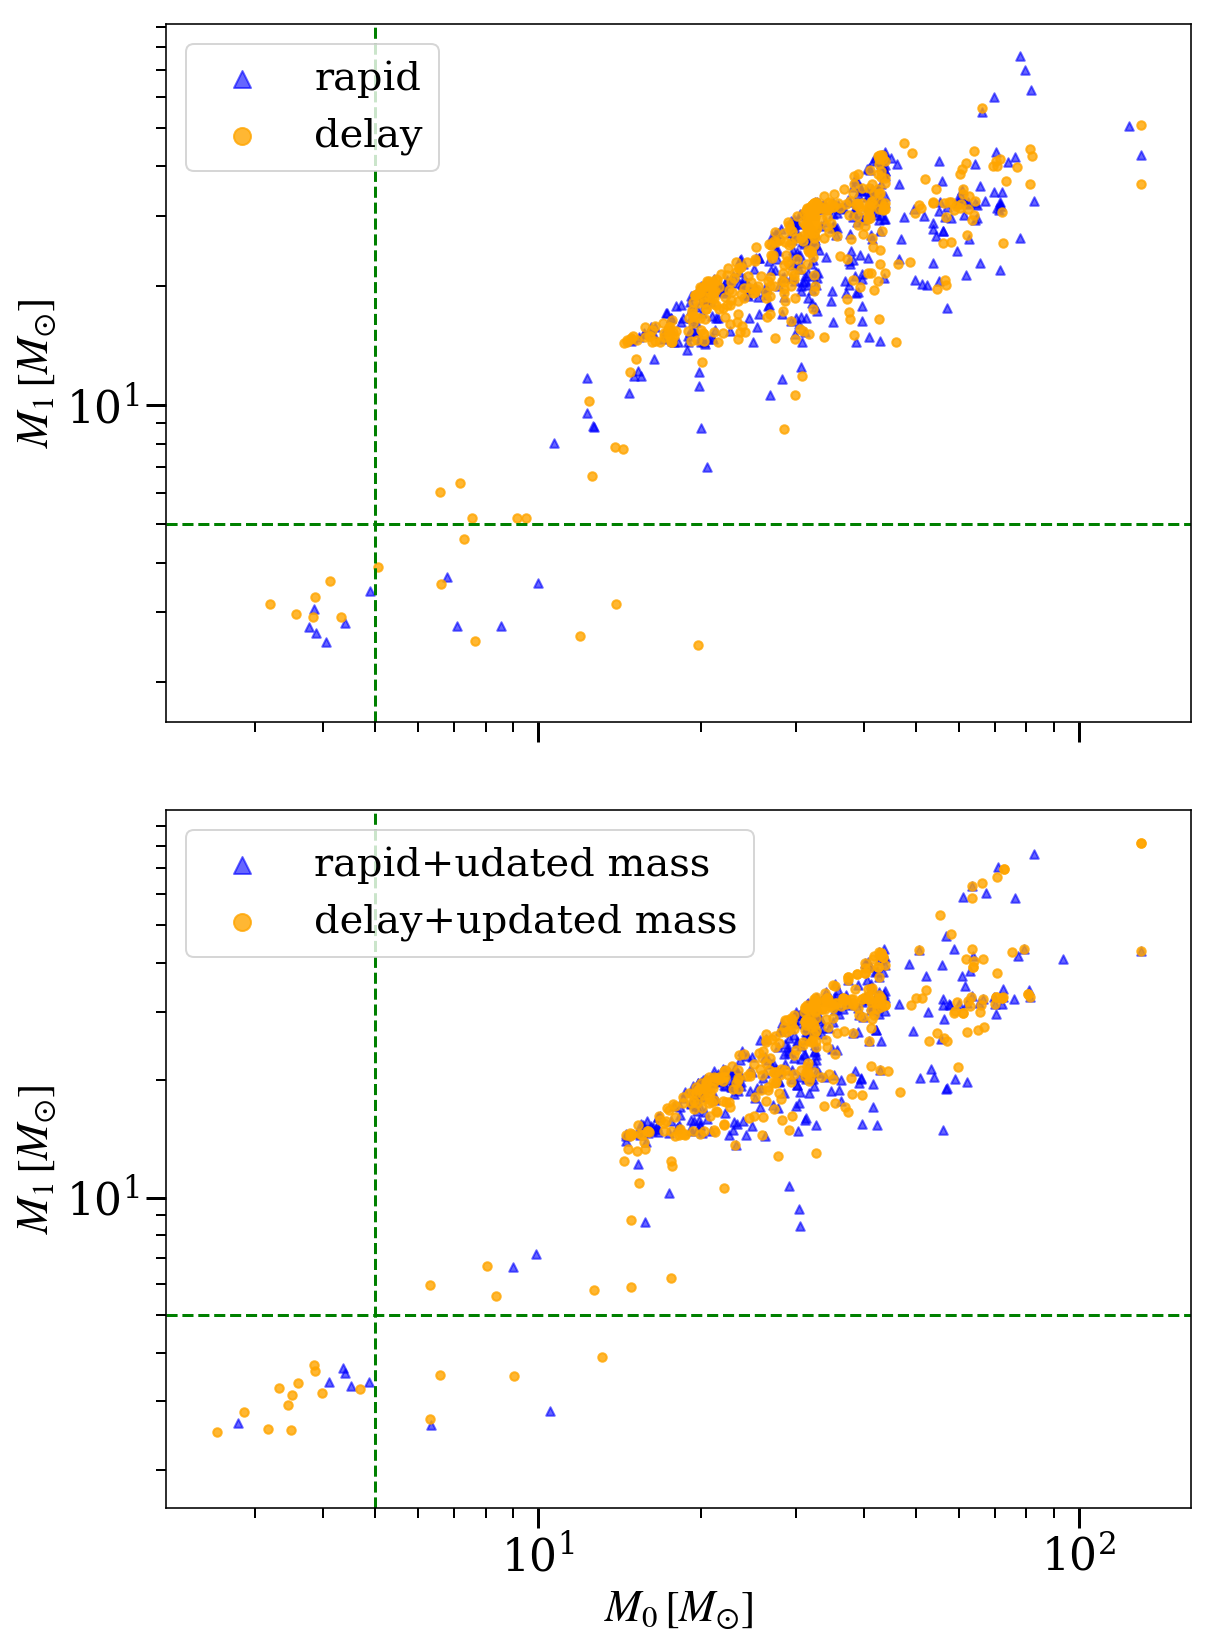

In [20]:
##BBH mergers in models
co_type = 'BBH'

m0 = []; m1 = []; bbh_type = []; id_bh1 = []; id_bh2 = []; types_model = []
for ii in range(len(paths)):
    #print(paths[ii])
    bbh_col = np.genfromtxt(paths[ii]+'GWcap_'+co_type+'.dat')
    three_col = bbh_col[:,12]
    bbh_mer = np.genfromtxt(paths[ii]+'Incluster_'+co_type+'.dat')
    bbh_esc = np.genfromtxt(paths[ii]+'Esc_'+co_type+'.dat')
    t_merger = bbh_esc[:,2]+bbh_esc[:,3]
    
    m0 = m0+list(bbh_col[:,10][three_col==-100])
    m1 = m1+list(bbh_col[:,11][three_col==-100])
    bbh_type = bbh_type+list(np.full_like(bbh_col[:,10][three_col==-100], 1))
    types_model=types_model+list(np.full_like(bbh_col[:,10][three_col==-100], model_type[ii]))
    
    m0 = m0+list(bbh_mer[:,7])
    m1 = m1+list(bbh_mer[:,8])
    bbh_type = bbh_type+list(np.full_like(bbh_mer[:,7], 2))
    types_model = types_model+list(np.full_like(bbh_mer[:,7], model_type[ii]))
    
    m0=m0+list(bbh_esc[:,4][t_merger<=14000.])
    m1=m1+list(bbh_esc[:,5][t_merger<=14000.])
    bbh_type = bbh_type+list(np.full_like(bbh_esc[:,4][t_merger<=14000.], 3))
    types_model = types_model+list(np.full_like(bbh_esc[:,4][t_merger<=14000.], model_type[ii]))

M0 = np.maximum(m0,m1)
M1 = np.minimum(m0,m1)
types_model = np.array(types_model)

fig, axs = plt.subplots(nrows=2, figsize=(9,12), sharex=True)
axs[0].scatter(M0[types_model==1], M1[types_model==1], marker='^',
            alpha=0.6, s=18, color = 'b', label='rapid')
axs[0].scatter(M0[types_model==3], M1[types_model==3],
            alpha=0.8, s=18, color='orange', label='delay')
axs[0].axhline(y=5, ls='--', color='green')
axs[0].axvline(x=5, ls='--', color='green')
#axs[0].set_xlabel(r'$M_0\,[M_{\odot}]$')
axs[0].set_ylabel(r'$M_1\,[M_{\odot}]$')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].tick_params('both', length=10, width=1.5, which='major')
axs[0].tick_params('both', length=5, width=1, which='minor')
axs[0].legend(loc='upper left', fontsize=20, markerscale=2)

axs[1].scatter(M0[types_model==2], M1[types_model==2], marker='^',
            alpha=0.6, s=18, color = 'b', label='rapid+udated mass')
axs[1].scatter(M0[types_model==4], M1[types_model==4],
            alpha=0.8, s=18, color='orange', label='delay+updated mass')
axs[1].axhline(y=5, ls='--', color='green')
axs[1].axvline(x=5, ls='--', color='green')
axs[1].set_xlabel(r'$M_0\,[M_{\odot}]$')
axs[1].set_ylabel(r'$M_1\,[M_{\odot}]$')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].tick_params('both', length=10, width=1.5, which='major')
axs[1].tick_params('both', length=5, width=1, which='minor')
axs[1].legend(loc='upper left', fontsize=20, markerscale=2)
fig.tight_layout()

#plt.savefig(savepath+'BBH_masses.pdf', dpi=300)

/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:20: UserWarning: genfromtxt: Empty input file: "/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc6752/allfixed/n8-rv0.5-rg8-z0.0002_iccatalog_alloff_cotdeoff_rerun/GWcap_NSBH.dat"
/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:20: UserWarning: genfromtxt: Empty input file: "/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc6752/allfixed/n8-rv0.5-rg8-z0.0002_iccatalog_nstde0.2_wdtc_wdmass_v1/GWcap_NSBH.dat"
/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:20: UserWarning: genfromtxt: Empty input file: "/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc6752/allfixed/n8-rv0.5-rg8-z0.0002_iccatalog_nstde0.2_wdtc_wdmass_v1_delay/GWcap_NSBH.dat"
/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:20: UserWarning: genfromtxt: Empty input file: "/pr

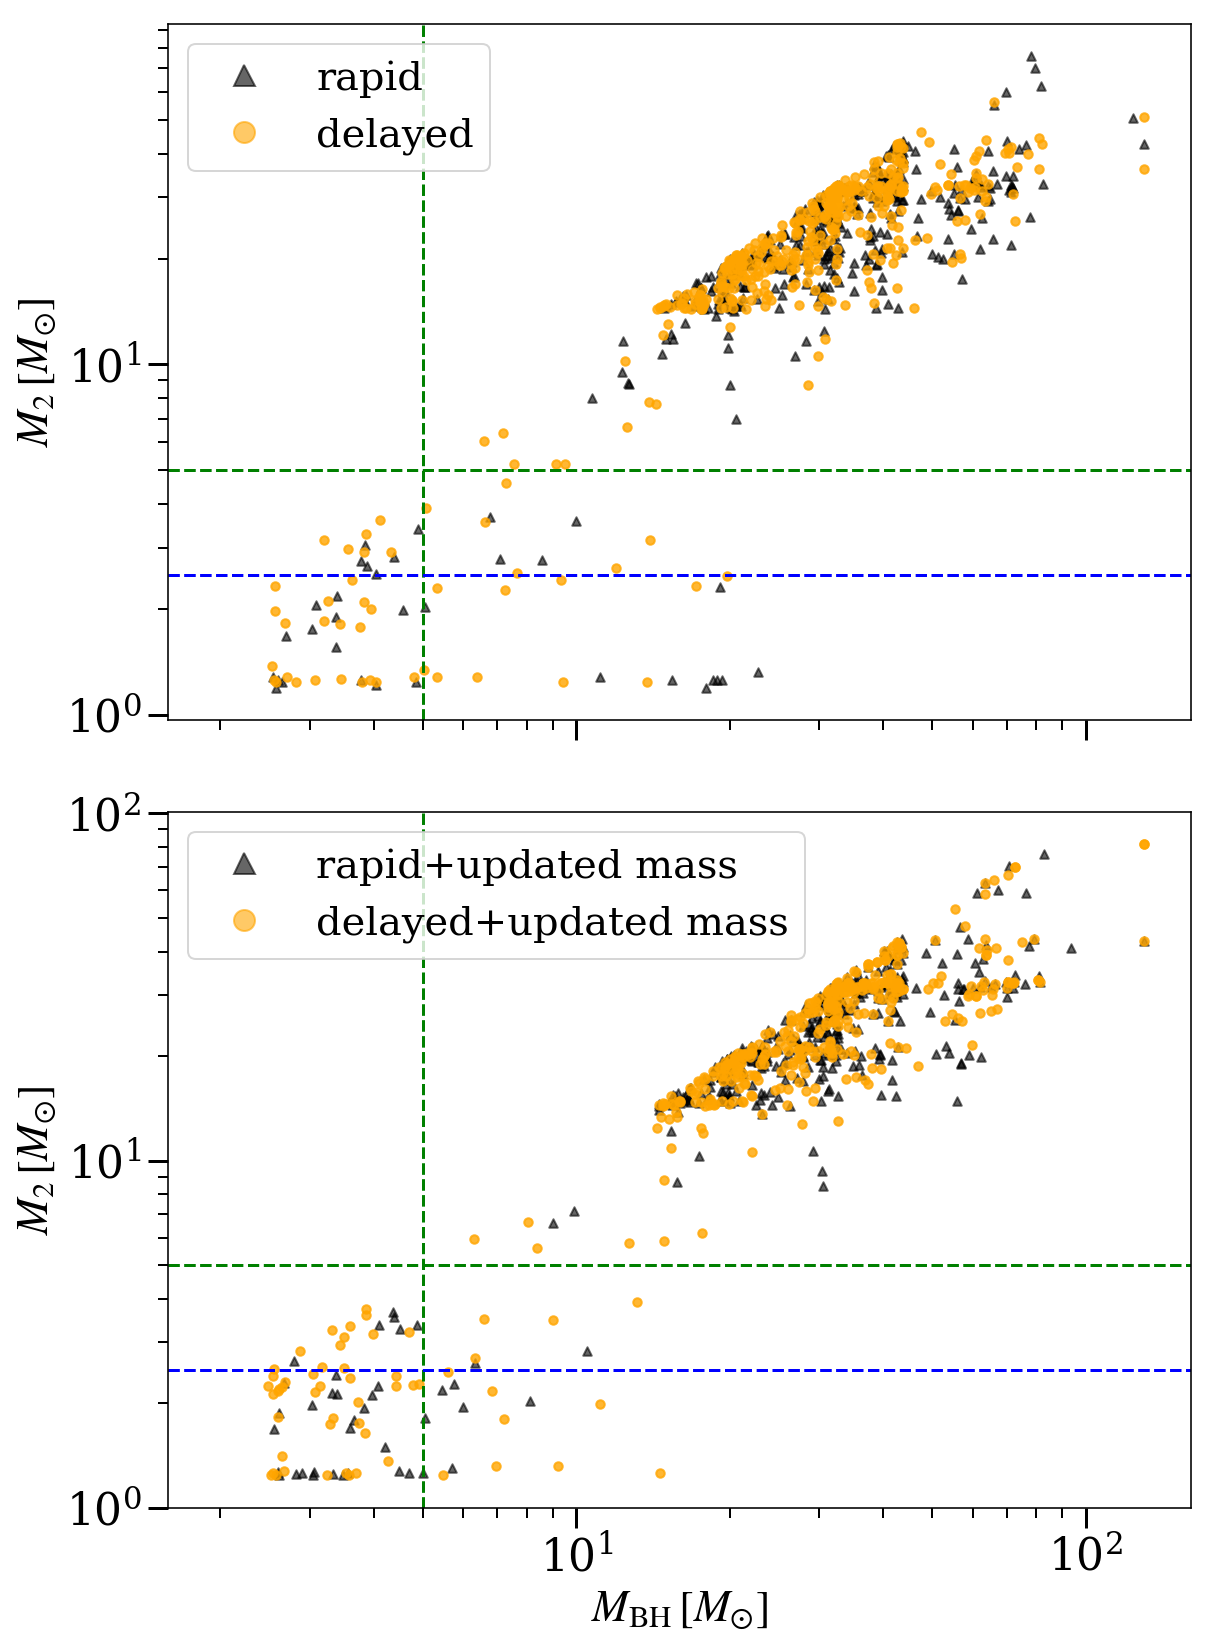

In [25]:
##NSBH mergers in models
co_type = ['NSBH', 'BBH']

m0 = [[],[]]; m1 = [[],[]]; bbh_type = [[],[]]; id_bh1 = [[],[]]; id_bh2 = [[],[]]; types_model = [[],[]]
M0 = [[],[]]; M1 = [[],[]]

btri_1=mlines.Line2D([], [],  linestyle = 'None', color='k', marker='^',
                  markersize=7, alpha=0.6, label='rapid')
odot_1=mlines.Line2D([], [],  linestyle = 'None', color='orange', marker='o',
                  markersize=7, alpha=0.6, label='delayed')
btri_2=mlines.Line2D([], [],  linestyle = 'None', color='k', marker='^',
                  markersize=7, alpha=0.6, label='rapid+updated mass')
odot_2=mlines.Line2D([], [],  linestyle = 'None', color='orange', marker='o',
                  markersize=7, alpha=0.6, label='delayed+updated mass')

fig, axs = plt.subplots(nrows=2, figsize=(9,12), sharex=True)
for xx in range(len(co_type)):
    for ii in range(len(paths)):
        #print(paths[ii])
        bbh_col = np.genfromtxt(paths[ii]+'GWcap_'+co_type[xx]+'.dat')
        #print(len(bbh_col))
        if len(bbh_col)>0:
            if len(bbh_col.shape)>1:
                three_col = bbh_col[:,12]
                m0[xx] = m0[xx]+list(bbh_col[:,10][three_col==-100])
                m1[xx] = m1[xx]+list(bbh_col[:,11][three_col==-100])
                bbh_type[xx] = bbh_type[xx]+list(np.full_like(bbh_col[:,10][three_col==-100], 1))
                types_model[xx]=types_model[xx]+list(np.full_like(bbh_col[:,10][three_col==-100], model_type[ii]))
            else:
                #print(bbh_col)
                three_col = bbh_col[12]
                m0[xx] = m0[xx]+list(bbh_col[10][three_col==-100])
                m1[xx] = m1[xx]+list(bbh_col[11][three_col==-100])
                bbh_type[xx] = bbh_type[xx]+list(np.full_like(bbh_col[10][three_col==-100], 1))
                types_model[xx]=types_model[xx]+list(np.full_like(bbh_col[10][three_col==-100], model_type[ii]))
            
        bbh_mer = np.genfromtxt(paths[ii]+'Incluster_'+co_type[xx]+'.dat')
        m0[xx] = m0[xx]+list(bbh_mer[:,7])
        m1[xx] = m1[xx]+list(bbh_mer[:,8])
        bbh_type[xx] = bbh_type[xx]+list(np.full_like(bbh_mer[:,7], 2))
        types_model[xx] = types_model[xx]+list(np.full_like(bbh_mer[:,7], model_type[ii]))
        
        bbh_esc = np.genfromtxt(paths[ii]+'Esc_'+co_type[xx]+'.dat')
        if len(bbh_esc)>0:
            if len(bbh_esc.shape)>1:
                t_merger = bbh_esc[:,2]+bbh_esc[:,3]
                m0[xx]=m0[xx]+list(bbh_esc[:,4][t_merger<=14000.])
                m1[xx]=m1[xx]+list(bbh_esc[:,5][t_merger<=14000.])
                bbh_type[xx] = bbh_type[xx]+list(np.full_like(bbh_esc[:,4][t_merger<=14000.], 3))
                types_model[xx] = types_model[xx]+list(np.full_like(bbh_esc[:,4][t_merger<=14000.], model_type[ii]))
            else:
                t_merger = bbh_esc[2]+bbh_esc[3]
                m0[xx]=m0[xx]+list(bbh_esc[4][t_merger<=14000.])
                m1[xx]=m1[xx]+list(bbh_esc[5][t_merger<=14000.])
                bbh_type[xx] = bbh_type[xx]+list(np.full_like(bbh_esc[4][t_merger<=14000.], 3))
                types_model[xx] = types_model[xx]+list(np.full_like(bbh_esc[4][t_merger<=14000.], model_type[ii]))
            
    
    M0[xx] = np.maximum(m0[xx],m1[xx])
    M1[xx] = np.minimum(m0[xx],m1[xx])
    types_model[xx] = np.array(types_model[xx])

    axs[0].scatter(M0[xx][types_model[xx]==1], M1[xx][types_model[xx]==1], marker='^',
                alpha=0.6, s=18, color = 'k')
    axs[0].scatter(M0[xx][types_model[xx]==3], M1[xx][types_model[xx]==3],
                alpha=0.8, s=18, color='orange')
    axs[0].axhline(y=5, ls='--', color='green')
    axs[0].axvline(x=5, ls='--', color='green')
    axs[0].axhline(y=2.5, ls='--', color='b', lw=1.5)
    
    axs[1].scatter(M0[xx][types_model[xx]==2], M1[xx][types_model[xx]==2], marker='^',
            alpha=0.6, s=18, color = 'k')
    axs[1].scatter(M0[xx][types_model[xx]==4], M1[xx][types_model[xx]==4],
                alpha=0.8, s=18, color='orange')
    axs[1].axhline(y=5, ls='--', color='green')
    axs[1].axvline(x=5, ls='--', color='green')
    axs[1].axhline(y=2.5, ls='--', color='b', lw=1.5)
    
#axs[0].set_xlabel(r'$M_0\,[M_{\odot}]$')
axs[0].set_ylabel(r'$M_2\,[M_{\odot}]$')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].tick_params('both', length=10, width=1.5, which='major')
axs[0].tick_params('both', length=5, width=1, which='minor')
axs[0].legend(loc='upper left', fontsize=20, markerscale=1.5, handles=[btri_1, odot_1])

axs[1].set_xlabel(r'$M_{\rm{BH}}\,[M_{\odot}]$')
axs[1].set_ylabel(r'$M_2\,[M_{\odot}]$')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].tick_params('both', length=10, width=1.5, which='major')
axs[1].tick_params('both', length=5, width=1, which='minor')
axs[1].legend(loc='upper left', fontsize=20, markerscale=1.5, handles=[btri_2, odot_2])
fig.tight_layout()

plt.savefig(savepath+'BBH_NSBH_masses.pdf', dpi=300)

[130.084] 130.084
[130.084] 130.084
[130.084 130.084] 130.084
[130.084 130.084 130.084] 130.084


/software/anaconda3.6/lib/python3.6/site-packages/matplotlib/ticker.py:2512: UserWarning: AutoMinorLocator does not work with logarithmic scale
  warnings.warn('AutoMinorLocator does not work with logarithmic '


0.0 0.0


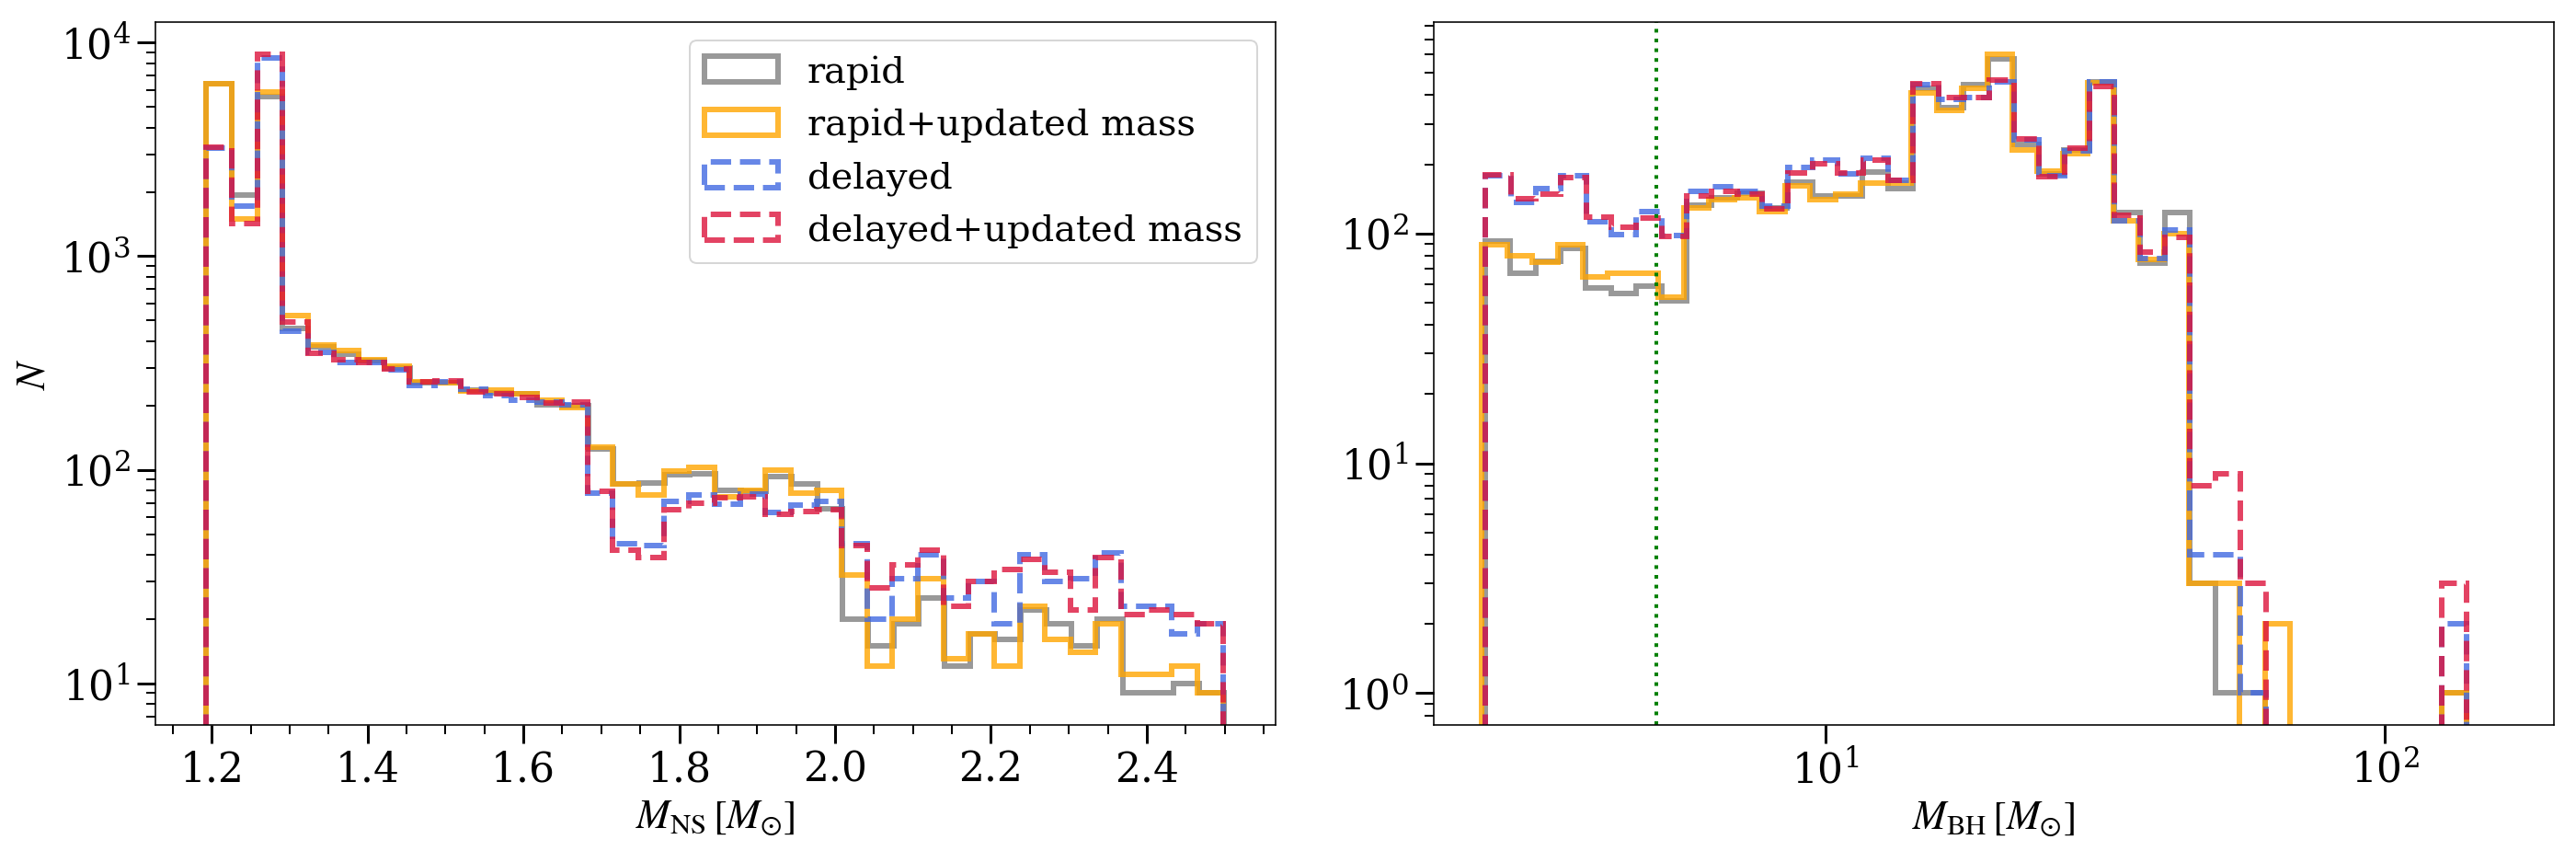

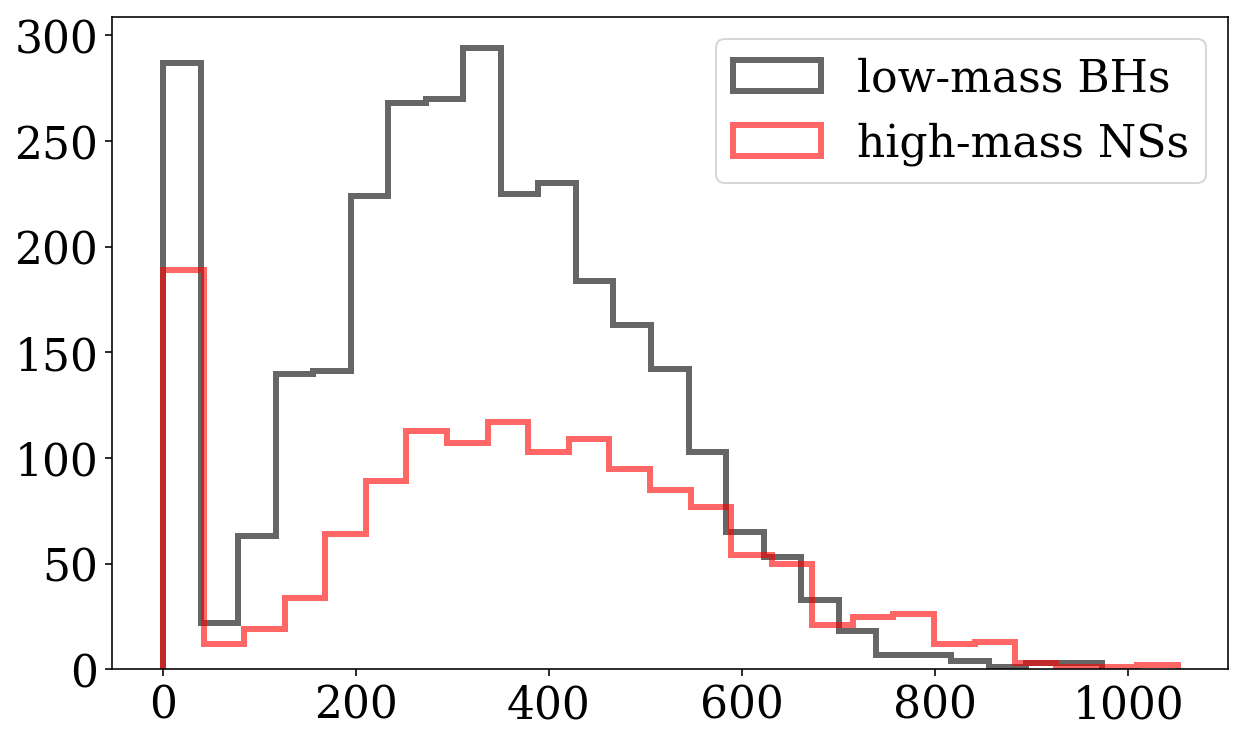

In [22]:
##The masses of all BHs and NSs ever formed in the models
all_mbh = [[],[],[],[]]; all_mns = [[],[],[],[]]
bh_kicks = []; ns_kicks = []
for xx in range(len(paths)):
    bhformation = np.genfromtxt(paths[xx]+'initial.bhformation.dat', usecols = (0,5,6,8))
    nsformation = np.genfromtxt(paths[xx]+'initial.nsformation.dat', usecols = (0,6,7,9))
    mbh = bhformation[:,2]; kickbh = bhformation[:,3]
    mns = nsformation[:,2]; kickns = nsformation[:,3]
    bh_kicks = bh_kicks + list(kickbh[mbh<=5.])
    ns_kicks = ns_kicks + list(kickns[mns>=2.])
    
    all_mbh[int(model_type[xx])-1] = all_mbh[int(model_type[xx])-1]+list(bhformation[:,2])
    all_mns[int(model_type[xx])-1] = all_mns[int(model_type[xx])-1]+list(nsformation[:,2])
    
    
fig, axs = plt.subplots(ncols = 2, figsize=(20,7))
lss = ['-', '-', '--', '--']
cs = ['gray', 'orange', 'royalblue', 'crimson']
labels = ['rapid', 'rapid+updated mass', 'delayed', 'delayed+updated mass']
axs[1].axvline(x=5, ls = 'dotted', color='green', lw=2)
for yy in range(4):
    print(np.array(all_mbh[yy])[np.array(all_mbh[yy])>=100], np.max(all_mbh[yy]))
    axs[1].hist(all_mbh[yy], 
            bins=np.logspace(np.log10(np.min(all_mbh[yy])), np.log10(np.max(all_mbh[yy])+10), 40), 
            histtype='step', ls = lss[yy], lw=3, color = cs[yy], alpha=0.8,
            label = labels[yy])
axs[1].set_xlim(xmin=2, xmax=200)
axs[1].set_yscale('log')
axs[1].set_xscale('log')
axs[1].set_xlabel(r'$M_{\rm{BH}}\,[M_{\odot}]$')


for yy in range(4):
    axs[0].hist(all_mns[yy], 
                bins = 40,
            #bins=np.logspace(np.log10(np.min(all_mns[yy])), np.log10(np.max(all_mns[yy])), 40), 
            histtype='step', ls = lss[yy], lw=3, color = cs[yy], alpha=0.8,
            label = labels[yy])
axs[0].set_yscale('log')
#axs[0].set_xscale('log')
axs[0].legend(loc='best', fontsize=20)
axs[0].set_xlabel(r'$M_{\rm{NS}}\,[M_{\odot}]$')
axs[0].set_ylabel(r'$N$')

#axs[0].tick_params('both',length=4,width=0.7,which='both',direction = 'out')
#axs[1].tick_params('both',length=4,width=0.7,which='both',direction = 'out')
axs[0].xaxis.set_minor_locator(AutoMinorLocator())
axs[0].tick_params('both', length=10, width=1.5, which='major')
axs[0].tick_params('both', length=5, width=1, which='minor')
axs[1].xaxis.set_minor_locator(AutoMinorLocator())
axs[1].tick_params('both', length=10, width=1.5, which='major')
axs[1].tick_params('both', length=5, width=1, which='minor')
fig.tight_layout()

plt.savefig(savepath+'all_formed_bh_ns_masses.pdf', dpi=300)


print(np.min(bh_kicks), np.min(ns_kicks))
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(bh_kicks, bins=25,
        label='low-mass BHs', color='k', lw=3, alpha=0.6, histtype='step')
ax.hist(ns_kicks, bins=25,
        label = 'high-mass NSs', color='r', lw=3, alpha=0.6, histtype='step')
ax.legend(loc='best')

12.12367808292
12.02176239644
12.00868534692
12.02849932416
12.0382750564
11.9913264376
11.951894861560001
11.95315951172
11.987143104440001
11.95966024544
11.9818078194
12.11544773428
2832 16 2848
0 [15.44198034  6.55935005]
2851 29 2880
1 []
2765 10 2775
2 []
3046 27 3073
3 [5.95760084 7.04868477 7.00148995]


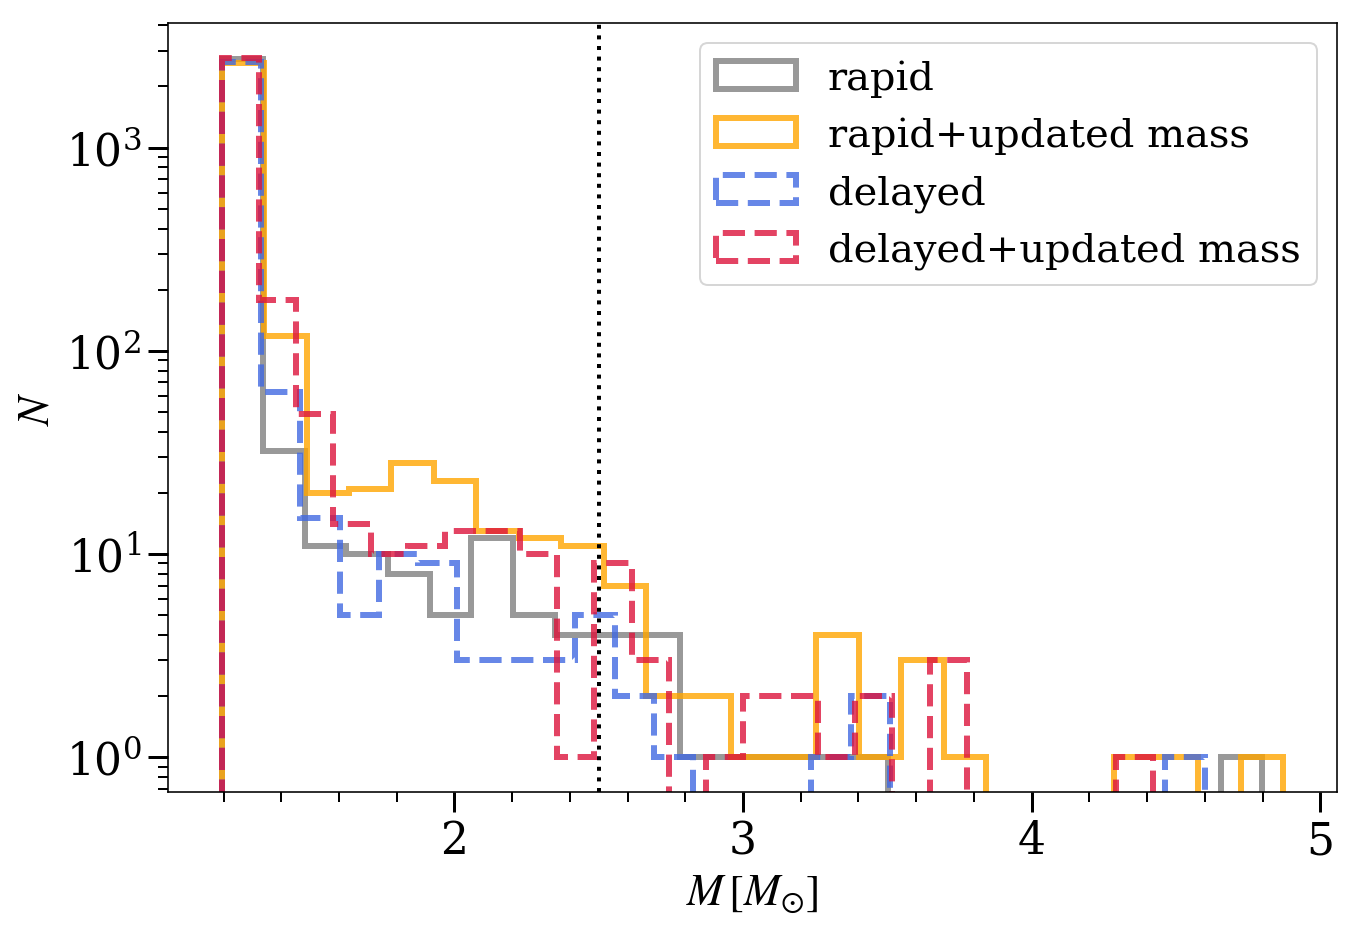

In [23]:
##Black hole and neutron star mass at late times (12 Gyr here)
M_bh = [[],[],[],[]]; M_ns = [[],[],[],[]]
for xx in range(len(paths)):
    snapt_float, snaptime_sort = bh_snaps(paths[xx])
    
    t_conv = dyn.conv('t', paths[xx]+'initial.conv.sh')
    
    for yy in range(len(snaptime_sort)):
        if float(snaptime_sort[yy])*t_conv>=11950.:
            bh_h5 = cmct.Snapshot(fname=paths[xx]+'initial.blackhole.snapshots.h5', 
                                    snapshot_name='/t='+snaptime_sort[yy], 
                                    conv=paths[xx]+'initial.conv.sh', 
                                    dist=4.125, # distance to cluster in kpc
                                    z=0.0002)
            print(bh_h5.age)
            binflag = np.array(bh_h5.data['binflag'])
            m = np.array(bh_h5.data['m_MSUN'])[binflag!=1]
            k0 = np.array(bh_h5.data['bin_startype0'])[binflag==1]; k1 = np.array(bh_h5.data['bin_startype1'])[binflag==1]
            m0 = np.array(bh_h5.data['m0_MSUN'])[binflag==1]; m1 = np.array(bh_h5.data['m1_MSUN'])[binflag==1]
            
            M_bh[int(model_type[xx])-1] = M_bh[int(model_type[xx])-1]+list(m)
            for zz in range(len(k0)):
                if k0[zz]==14:
                    M_bh[int(model_type[xx])-1].append(m0[zz])
                if k1[zz]==14:
                    M_bh[int(model_type[xx])-1].append(m1[zz])
                        
            break

    t_old = 14000.
    with open(paths[xx]+'initial.morepulsars.dat', 'r') as fpsr:
        next(fpsr)
        for line in fpsr:
            datapsr = line.split()
            if float(datapsr[1])*t_conv > t_old:
                break
            if float(datapsr[1])*t_conv>=11950.:
                if int(datapsr[2])!=1:
                    M_ns[int(model_type[xx])-1].append(float(datapsr[5]))
                else:
                    if int(datapsr[11])==13:
                        M_ns[int(model_type[xx])-1].append(float(datapsr[5]))
                    if int(datapsr[12])==13:
                        M_ns[int(model_type[xx])-1].append(float(datapsr[6]))
                
                t_old = float(datapsr[1])*t_conv

#print(M_bh)
#print(M_ns)               

fig, axs = plt.subplots(figsize=(10,7))
lss = ['-', '-', '--', '--']
cs = ['gray', 'orange', 'royalblue', 'crimson']
labels = ['rapid', 'rapid+updated mass', 'delayed', 'delayed+updated mass']

#axs.axvline(x=5, ls = 'dotted', color='green', lw=2)
axs.axvline(x=2.5, ls = 'dotted', color='k', lw=2)
for ii in range(4):
    print(len(M_ns[ii]), len(M_bh[ii]), len(M_ns[ii]+M_bh[ii]))
    print(ii, np.array(M_ns[ii]+M_bh[ii])[np.array(M_ns[ii]+M_bh[ii])>5])
    axs.hist(np.array(M_ns[ii]+M_bh[ii])[np.array(M_ns[ii]+M_bh[ii])<=5.],
             bins=25,
            #bins=np.logspace(np.log10(np.min(M_ns[ii]+M_bh[ii])), np.log10(np.max(M_ns[ii]+M_bh[ii])), 20), 
            histtype='step', ls = lss[ii], lw=3, color = cs[ii], alpha=0.8,
            label = labels[ii])
    
    #axs.hist(M_bh[ii], 
    #            bins=10,
    #        #bins=np.logspace(np.log10(np.min(M_bh[ii])), np.log10(np.max(M_bh[ii])+10), 20), 
    #        histtype='step', ls = lss[ii], lw=3, color = cs[ii], alpha=0.8,
    #        label = labels[ii])

#axs.set_xscale('log')
axs.set_yscale('log')
axs.xaxis.set_minor_locator(AutoMinorLocator())
axs.tick_params('both', length=10, width=1.5, which='major')
axs.tick_params('both', length=5, width=1, which='minor')
axs.set_xlabel(r'$M\,[M_{\odot}]$')
axs.set_ylabel(r'$N$')
axs.legend(loc='upper right', fontsize=20)
    
fig.tight_layout()

plt.savefig(savepath+'Mbh_ns_all_12Gyr.pdf', dpi=300)

In [8]:
##Number of TDEs in different models
##For collisions with more than one star,
##e.g., one NS colliding with 2 MS,
##there will be two TDE printouts in the error.out file
##may want to subtract the number here; write in paper
N_tde = []

Mnew_all = [[],[]]; Macc_all = [[],[]]
Bnew_all = [[],[]]; Bold_all = [[],[]]; Pnew_all = [[],[]]; Pold_all = [[],[]]
idtde_all = []; idtde_latercoll_all = []
idtde_msp_all = []; idtde_msp_norepeater = []
ttde = []

ttot_myr = []
#fig, axs = plt.subplots(nrows=2, ncols=2, figsize = (16, 12))
for xx in range(len(paths)):
    m_ns = []; B_ns = []; Ospin_ns = []
    m_new = []; B_new = []; Ospin_new = []; Macc = []
    m_star_all = []; k_star_all = []
    nbh = 0
    
    error_out = paths[xx]+'error.out'
    with open(error_out, 'r') as ferr:
        for line in ferr:
            data=line.split()
            if data[0]=='Before':
                m_star = float(data[3].split('=')[1])
                r_star = float(data[4].split('=')[1])
                k_star = float(data[5].split('=')[1])
                m_ns.append(float(data[6].split('=')[1]))
                B_ns.append(float(data[7].split('=')[1]))
                Ospin_ns.append(float(data[8].split('=')[1]))
                
                m_star_all.append(m_star); k_star_all.append(k_star)
            if data[0]=='After':
                m_new.append(float(data[3].split('=')[1]))
                B_new.append(float(data[4].split('=')[1]))
                Ospin_new.append(float(data[5].split('=')[1]))
                Macc.append(float(data[6].split('=')[1]))
    
    Psec_old = twopi*yearsc/np.array(Ospin_ns)
    Psec_new = twopi*yearsc/np.array(Ospin_new)
    
    print(len(Psec_old), len(Psec_old[Psec_old<=0.03]), len(Psec_new[Psec_new<=0.03]))  ##write in paper
    
    print(xx, len(Psec_new[np.array(m_new)<=2.5]))
    N_tde.append(len(Psec_new))
    
    idtde = np.full(len(m_star_all),-100)
    ttde.append(np.full(len(m_star_all),-100.0))
    
    if xx <= ab_cut:
        Mnew_all[0] = Mnew_all[0]+m_new
        Macc_all[0] = Macc_all[0]+Macc
        Bold_all[0] = Bold_all[0]+B_ns
        Bnew_all[0] = Bnew_all[0]+B_new
        Pold_all[0] = Pold_all[0]+list(Psec_old)
        Pnew_all[0] = Pnew_all[0]+list(Psec_new)
    else:
        Mnew_all[1] = Mnew_all[1]+m_new
        Macc_all[1] = Macc_all[1]+Macc
        Bold_all[1] = Bold_all[1]+B_ns
        Bnew_all[1] = Bnew_all[1]+B_new
        Pold_all[1] = Pold_all[1]+list(Psec_old)
        Pnew_all[1] = Pnew_all[1]+list(Psec_new)
        
        
    ##Check the collision file
    nsms_coll = np.genfromtxt(paths[xx]+'ns_nsms_coll.dat')
    t_myr = nsms_coll[:,1]; k3 = nsms_coll[:,12]; k4 = nsms_coll[:,13]
    ttot_myr = ttot_myr+list(t_myr)
    #print('num coll', len(t_myr))
    #print('repeat', len(k3[k3!=-100]), len(k4[k4!=-100]))
    print('t_myr', len(t_myr))
    
    ns_collproduct = np.genfromtxt(paths[xx]+'ns_collproduct_all.dat')
    mcollall = [ns_collproduct[:,5], ns_collproduct[:,6], ns_collproduct[:,7], ns_collproduct[:,8]]
    kcollall = [ns_collproduct[:,10], ns_collproduct[:,11], ns_collproduct[:,12], ns_collproduct[:,13]]
    idm_nscol = ns_collproduct[:,2].astype(np.int)
    idall_nscol = [ns_collproduct[:,14].astype(np.int),ns_collproduct[:,15].astype(np.int),
                   ns_collproduct[:,16].astype(np.int),ns_collproduct[:,17].astype(np.int)]
    t_nscoll =  ns_collproduct[:,1]
    
    bh_collproduct = np.genfromtxt(paths[xx]+'bh_collproduct_all.dat')
    bh_mcollall = [bh_collproduct[:,5], bh_collproduct[:,6], bh_collproduct[:,7], bh_collproduct[:,8]]
    bh_kcollall = [bh_collproduct[:,10], bh_collproduct[:,11], bh_collproduct[:,12], bh_collproduct[:,13]]
    
    ns_merproduct = np.genfromtxt(paths[xx]+'ns_mergerproduct_all.dat')
    idm_nsmer = ns_merproduct[:,2].astype(np.int)
    t_nsmer = ns_merproduct[:,1]
    idall_nsmer = [ns_merproduct[:,10].astype(np.int),ns_merproduct[:,11].astype(np.int)]
    
    for kk in range(len(m_star_all)):
        for zz in range(len(mcollall)):
            if len(mcollall[zz][mcollall[zz]==round(m_star_all[kk], 6)])>0:
                if len(mcollall[zz][mcollall[zz]==round(m_star_all[kk], 6)])>1:
                    print('Oh no')
                    #print(mcollall[zz][mcollall[zz]==round(m_star_all[kk], 6)], m_star_all[kk])
                    if mcollall[zz-1][mcollall[zz]==round(m_star_all[kk], 6)][0]==m_ns[kk]:
                        print('yes')
                        if kcollall[zz][mcollall[zz]==round(m_star_all[kk], 6)][0]==k_star_all[kk]:
                            idtde[kk]=idm_nscol[mcollall[zz]==round(m_star_all[kk], 6)][0]
                            ttde[xx][kk] = t_nscoll[mcollall[zz]==round(m_star_all[kk], 6)][0]
                            continue
                            
                if kcollall[zz][mcollall[zz]==round(m_star_all[kk], 6)][0]==k_star_all[kk]:
                    idtde[kk]=idm_nscol[mcollall[zz]==round(m_star_all[kk], 6)]
                    ttde[xx][kk] = t_nscoll[mcollall[zz]==round(m_star_all[kk], 6)]
                    #print(mcollall[zz][mcollall[zz]==round(m_star_all[kk],6)], m_star_all[kk])
                    
        if idtde[kk]==-100:
            if len(kcollall[0][(mcollall[0]+mcollall[1])==m_star_all[kk]])>0:
                #print(m_star_all[kk])
                #print(mcollall[0][(mcollall[0]+mcollall[1])==m_star_all[kk]][0], mcollall[1][(mcollall[0]+mcollall[1])==m_star_all[kk]][0])
                if kcollall[0][(mcollall[0]+mcollall[1])==m_star_all[kk]][0]<=1. or kcollall[1][(mcollall[0]+mcollall[1])==m_star_all[kk]][0]<=1.:
                    idtde[kk]=idm_nscol[(mcollall[0]+mcollall[1])==m_star_all[kk]]
                    ttde[xx][kk] = t_nscoll[(mcollall[0]+mcollall[1])==m_star_all[kk]]
                    
        if idtde[kk]==-100:
            if len(kcollall[0][np.round((mcollall[0]+mcollall[1]), 5)==m_star_all[kk]])>0:
                #print(mcollall[0][np.round((mcollall[0]+mcollall[1]), 5)==m_star_all[kk]])
                #print(mcollall[1][np.round((mcollall[0]+mcollall[1]), 5)==m_star_all[kk]])
                #print(m_star_all[kk])
                if kcollall[0][np.round((mcollall[0]+mcollall[1]), 5)==m_star_all[kk]][0]<=1. or kcollall[1][np.round((mcollall[0]+mcollall[1]),5)==m_star_all[kk]][0]<=1.:
                    #print(m_star_all[kk])
                    idtde[kk]=idm_nscol[np.round((mcollall[0]+mcollall[1]), 5)==m_star_all[kk]]
                    ttde[xx][kk] = t_nscoll[np.round((mcollall[0]+mcollall[1]), 5)==m_star_all[kk]]
                    #print(idtde[kk])
                    
        if idtde[kk]==-100:
            if len(kcollall[0][np.round((mcollall[0]+mcollall[1]), 5)==round(m_star_all[kk],5)])>0:
                if kcollall[0][np.round((mcollall[0]+mcollall[1]), 5)==round(m_star_all[kk],5)][0]<=1. or kcollall[1][np.round((mcollall[0]+mcollall[1]),5)==round(m_star_all[kk],5)][0]<=1.:
                    idtde[kk]=idm_nscol[np.round((mcollall[0]+mcollall[1]), 5)==round(m_star_all[kk],5)]
                    ttde[xx][kk] = t_nscoll[np.round((mcollall[0]+mcollall[1]), 5)==round(m_star_all[kk],5)]
                    
        if idtde[kk]==-100:
            for zz in range(len(bh_mcollall)):
                if len(bh_mcollall[zz][bh_mcollall[zz]==round(m_star_all[kk], 6)])>0:
                    if len(bh_mcollall[zz][bh_mcollall[zz]==round(m_star_all[kk], 6)])>1:
                        print('Oh no')
                        #print(bh_mcollall[zz][bh_mcollall[zz]==round(m_star_all[kk], 6)])
                    if bh_kcollall[zz][bh_mcollall[zz]==round(m_star_all[kk], 6)][0]==k_star_all[kk]:
                        nbh+=1                
            
            
    print('num of TDE?', len(idtde[idtde>=0]))
    print(np.array(m_star_all)[idtde==-100])
    print('nbh', nbh)
    print('ttde', len(ttde[xx]), len(t_myr))

    idtde_old = idtde
    idtde = np.array(list(Counter(idtde).keys()))
    #print(idtde)
    idtde_all.append(idtde[idtde>0])
    
    ##Counting subsequent mergers/collisions
    idtde_latercoll = []
    idtde_latercoll_msp = []
    for hh in range(len(idtde)):
        if idtde[hh]==0 or idtde[hh]==-100:
            continue
        for gg in range(len(idall_nscol)):
            if idtde[hh] in idall_nscol[gg] and idm_nscol[idall_nscol[gg]==idtde[hh]][0] not in idtde:
                #print('repeated collisions', idall_nscol[gg][idall_nscol[gg]==idtde[hh]], idtde[hh])
                idtde_latercoll.append(idm_nscol[idall_nscol[gg]==idtde[hh]][0])
                if Psec_new[hh]<=0.03:
                    idtde_latercoll_msp.append(idm_nscol[idall_nscol[gg]==idtde[hh]][0])
                
        for gg in range(len(idall_nsmer)):
            if idtde[hh] in idall_nsmer[gg]:
                for ff in range(len(idm_nsmer[idall_nsmer[gg]==idtde[hh]])):
                    if idm_nsmer[idall_nsmer[gg]==idtde[hh]][ff]!=idtde[hh]:
                        idtde_latercoll.append(idm_nsmer[idall_nsmer[gg]==idtde[hh]][ff])       
                        if Psec_new[hh]<=0.03:
                            idtde_latercoll_msp.append(idm_nsmer[idall_nsmer[gg]==idtde[hh]][ff])
    
    #print(idtde_latercoll)                    
    for hh in range(len(idtde_latercoll)):
        if idtde_latercoll[hh]==0:
            continue
        for gg in range(len(idall_nscol)):
            if idtde_latercoll[hh] in idall_nscol[gg] and idm_nscol[idall_nscol[gg]==idtde_latercoll[hh]][0] not in idtde:
                idtde_latercoll.append(idm_nscol[idall_nscol[gg]==idtde_latercoll[hh]][0])
                #print(gg, idall_nscol[gg][idall_nscol[gg]==idtde_latercoll[hh]], idtde_latercoll[hh])
                k_temp = [kcollall[0][idall_nscol[gg]==idtde_latercoll[hh]],
                         kcollall[1][idall_nscol[gg]==idtde_latercoll[hh]],
                         kcollall[2][idall_nscol[gg]==idtde_latercoll[hh]],
                         kcollall[3][idall_nscol[gg]==idtde_latercoll[hh]]]
                if idtde_latercoll[hh] in idtde_latercoll_msp:# or (0. in k_temp or 1. in k_temp):
                     idtde_latercoll_msp.append(idm_nscol[idall_nscol[gg]==idtde_latercoll[hh]][0])
                
        for gg in range(len(idall_nsmer)):
            if idtde_latercoll[hh] in idall_nsmer[gg]:
                for ff in range(len(idm_nsmer[idall_nsmer[gg]==idtde_latercoll[hh]])):
                    if idm_nsmer[idall_nsmer[gg]==idtde_latercoll[hh]][ff]!=idtde_latercoll[hh]:
                        idtde_latercoll.append(idm_nsmer[idall_nsmer[gg]==idtde_latercoll[hh]][ff]) 
                        if idtde_latercoll[hh] in idtde_latercoll_msp:
                            idtde_latercoll_msp.append(idm_nsmer[idall_nsmer[gg]==idtde_latercoll[hh]][ff]) 
    
    #print(idtde_latercoll, idtde_latercoll_msp)
    idtde_latercoll = np.array(list(Counter(idtde_latercoll).keys()))
    idtde_latercoll_msp = list(Counter(idtde_latercoll_msp).keys())
    #print('later_msp', len(idtde_latercoll_msp))
    
    idtde_latercoll_all.append(idtde_latercoll)
    
    idtde_msp_all.append(np.array(list(Counter(list(idtde_old[(idtde_old>0) & (Psec_new<=0.03)])+ 
                                         idtde_latercoll_msp).keys())))
    print('num of tde msp?', len(idtde_msp_all[xx]))
    idtde_msp_norepeater.append(np.array(list(Counter(idtde_old[(idtde_old>0) & (Psec_new<=0.03)]).keys())))
    

##Rates of NS-MS TDEs
n_tde_9gyr  = []
for kk in range(len(ttde)):
    if len(ttde[kk])>0:
        n_tde_9gyr.append(len(ttde[kk][ttde[kk]>=9000.]))
print('mean number of TDEs at > 9 Gyr', np.mean(n_tde_9gyr))
print('TDE rates at > 9 Gyr', np.mean(n_tde_9gyr)/((13.8-9.)*10**9)*2.31*10**9)

0 0 0
0 0
t_myr 134
num of TDE? 0
[]
nbh 0
ttde 0 134
num of tde msp? 0
0 0 0
1 0
t_myr 226
num of TDE? 0
[]
nbh 0
ttde 0 226
num of tde msp? 0
0 0 0
2 0
t_myr 176
num of TDE? 0
[]
nbh 0
ttde 0 176
num of tde msp? 0
0 0 0
3 0
t_myr 248
num of TDE? 0
[]
nbh 0
ttde 0 248
num of tde msp? 0
166 21 166
4 166
t_myr 150
num of TDE? 163
[1.32149  1.16443  0.699864]
nbh 3
ttde 166 150
num of tde msp? 163
245 43 242
5 240
t_myr 219
num of TDE? 235
[0.855357 0.7274   0.90938  0.69688  2.07232  1.52365  1.09481  0.799474
 1.97147  0.794803]
nbh 8
ttde 245 219
num of tde msp? 240
236 44 235
6 234
t_myr 212
num of TDE? 229
[1.59918  1.23366  2.15575  0.8167   0.648148 1.13176  0.716384]
nbh 6
ttde 236 212
num of tde msp? 235
247 38 246
7 246
t_myr 221
num of TDE? 6
[0.568146  0.0848505 0.604998  1.04031   0.806983  0.9657    0.957734
 1.01074   0.579441  1.34243   0.848421  0.371959  0.531299  1.39884
 0.614155  0.59566   0.824443  0.904478  0.771063  0.68604   3.41334
 0.570305  1.08855   0.773451 

In [11]:
###Number of NS formed in WDWD collision and mergers
###PSR and non-PSR

N_ns_wdwdcoll = [[],[]]
N_wdwdcoll_tot = []
N_ns_wdwdmer = [[],[]]
N_wdwdmer_tot = []
id_wdwdcol_all = []; id_wdwdmer_all = []
id_wdwdcol_norepeater = []; id_wdwdmer_norepeater = []
type_wdwdcol_all = []; type_wdwdmer_all = []
type_wdwdcol_norepeater = []; type_wdwdmer_norepeater = []

for xx in range(len(paths)):
    t_conv = dyn.conv('t', paths[xx]+'initial.conv.sh')

    psrfile = paths[xx]+'initial.morepulsars.dat'
    
    wdwd_coll_file = np.genfromtxt(paths[xx]+'ns_wdwd_coll.dat')
    id_coll = wdwd_coll_file[:,2].astype(np.int)
    k0_coll = wdwd_coll_file[:,10].astype(np.int); k1_coll = wdwd_coll_file[:,11].astype(np.int)
    print('N_ns_wdwd_coll:', xx, len(id_coll))
    print('coll zeros', len(id_coll[id_coll==0]))
    N_wdwdcoll_tot.append(len(id_coll))
    k0_coll = k0_coll[id_coll!=0]; k1_coll = k1_coll[id_coll!=0]
    id_coll = id_coll[id_coll!=0]
    
    wdwd_mer_file = np.genfromtxt(paths[xx]+'ns_wdwd_merger.dat')
    print(len(wdwd_mer_file))
    if len(wdwd_mer_file)>0:
        id_mer = wdwd_mer_file[:,2].astype(np.int)
        k0_mer = wdwd_mer_file[:,8].astype(np.int); k1_mer = wdwd_mer_file[:,9].astype(np.int)
        print('N_ns_wdwd_mer:', xx, len(id_mer))
        print('mer zeros', len(id_mer[id_mer==0]))
        N_wdwdmer_tot.append(len(id_mer))
        k0_mer = k0_mer[id_mer!=0]; k1_mer = k1_mer[id_mer!=0]
        id_mer = id_mer[id_mer!=0]
        #print(id_mer)
    else:
        id_mer = np.array([])
        k0_mer = np.array([]); k1_mer = np.array([])
        print('N_ns_wdwd_mer:', xx, len(id_mer))
        print('mer zeros', len(id_mer))
        N_wdwdmer_tot.append(len(id_mer))
        
    
    ns_collproduct = np.genfromtxt(paths[xx]+'ns_collproduct_all.dat')
    idm_nscol = ns_collproduct[:,2].astype(np.int)
    idall_nscol = [ns_collproduct[:,14].astype(np.int),ns_collproduct[:,15].astype(np.int),
                   ns_collproduct[:,16].astype(np.int),ns_collproduct[:,17].astype(np.int)]
    
    ns_merproduct = np.genfromtxt(paths[xx]+'ns_mergerproduct_all.dat')
    idm_nsmer = ns_merproduct[:,2].astype(np.int)
    t_nsmer = ns_merproduct[:,1]
    idall_nsmer = [ns_merproduct[:,10].astype(np.int),ns_merproduct[:,11].astype(np.int)]
    
    ##Counting subsequent mergers/collisions
    ##Exclude the ones that go through TDEs and TDE subsequent mergers/collisions
    idcoll_latercoll = []
    idmer_latercoll = []
    typecoll_latercoll = []
    typemer_latercoll = []
    for hh in range(len(id_coll)):
        if id_coll[hh]==0:
            continue           
        for kk in range(len(idall_nscol)):
            if id_coll[hh] in idall_nscol[kk]:
                if idm_nscol[idall_nscol[kk]==id_coll[hh]][0] not in idtde_all[xx]: 
                    idcoll_latercoll.append(idm_nscol[idall_nscol[kk]==id_coll[hh]][0])
                    typecoll_latercoll.append(np.str(k0_coll[hh])+np.str(k1_coll[hh]))
        for kk in range(len(idall_nsmer)):
            if id_coll[hh] in idall_nsmer[kk]:
                for gg in range(len(idm_nsmer[idall_nsmer[kk]==id_coll[hh]])):
                    if idm_nsmer[idall_nsmer[kk]==id_coll[hh]][gg]!=id_coll[hh]:
                        idcoll_latercoll.append(idm_nsmer[idall_nsmer[kk]==id_coll[hh]][gg])
                        typecoll_latercoll.append(np.str(k0_coll[hh])+np.str(k1_coll[hh]))

                        
    for ll in range(len(id_mer)):
        if id_mer[ll]==0:
            continue
        for mm in range(len(idall_nscol)):
            if id_mer[ll] in idall_nscol[mm]:
                if idm_nscol[idall_nscol[mm]==id_mer[ll]][0] not in idtde_all[xx]:
                    idmer_latercoll.append(idm_nscol[idall_nscol[mm]==id_mer[ll]][0])
                    typemer_latercoll.append(np.str(k0_mer[ll])+np.str(k1_mer[ll]))

        for mm in range(len(idall_nsmer)):
            if id_mer[ll] in idall_nsmer[mm]:
                for nn in range(len(idm_nsmer[idall_nsmer[mm]==id_mer[ll]])):
                    if idm_nsmer[idall_nsmer[mm]==id_mer[ll]][nn]!=id_mer[ll]:
                        idmer_latercoll.append(idm_nsmer[idall_nsmer[mm]==id_mer[ll]][nn])
                        typemer_latercoll.append(np.str(k0_mer[ll])+np.str(k1_mer[ll]))
  

    for hh in range(len(idcoll_latercoll)):
        if idcoll_latercoll[hh]==0:
            continue 
        for kk in range(len(idall_nscol)):
            if idcoll_latercoll[hh] in idall_nscol[kk]:
                if idm_nscol[idall_nscol[kk]==idcoll_latercoll[hh]][0] not in idtde_all[xx]:
                    idcoll_latercoll.append(idm_nscol[idall_nscol[kk]==idcoll_latercoll[hh]][0])
                    typecoll_latercoll.append(typecoll_latercoll[hh])
                
        for kk in range(len(idall_nsmer)):
            if idcoll_latercoll[hh] in idall_nsmer[kk]:
                for gg in range(len(idm_nsmer[idall_nsmer[kk]==idcoll_latercoll[hh]])):
                    if idm_nsmer[idall_nsmer[kk]==idcoll_latercoll[hh]][gg]!=idcoll_latercoll[hh]:
                        idcoll_latercoll.append(idm_nsmer[idall_nsmer[kk]==idcoll_latercoll[hh]][gg])
                        typecoll_latercoll.append(typecoll_latercoll[hh])
                        
    for ll in range(len(idmer_latercoll)):
        if idmer_latercoll[ll]==0:
            continue
        for mm in range(len(idall_nscol)):
            if idmer_latercoll[ll] in idall_nscol[mm]:
                if idm_nscol[idall_nscol[mm]==idmer_latercoll[ll]][0] not in idtde_all[xx]:
                    idmer_latercoll.append(idm_nscol[idall_nscol[mm]==idmer_latercoll[ll]][0])
                    typemer_latercoll.append(typemer_latercoll[ll])
                
        for mm in range(len(idall_nsmer)):
            if idmer_latercoll[ll] in idall_nsmer[mm]:
                for nn in range(len(idm_nsmer[idall_nsmer[mm]==idmer_latercoll[ll]])):
                    if idm_nsmer[idall_nsmer[mm]==idmer_latercoll[ll]][nn]!=idmer_latercoll[ll]:
                        idmer_latercoll.append(idm_nsmer[idall_nsmer[mm]==idmer_latercoll[ll]][nn])
                        typemer_latercoll.append(typemer_latercoll[ll])
                
    
    #print(len(idcoll_latercoll))
    #print(idcoll_latercoll)
    #idcoll_latercoll == np.array(idcoll_latercoll)[np.array(idcoll_latercoll)!=0]
    #print(len(idcoll_latercoll))
    #print(len(idmer_latercoll))
    #print(idmer_latercoll)
    #idmer_latercoll == np.array(idmer_latercoll)[np.array(idmer_latercoll)!=0]
    #print(len(idmer_latercoll)) 
    
    id_wdwdcol_all.append(np.array(list(Counter(np.concatenate((id_coll, np.array(idcoll_latercoll)))).keys())))
    id_wdwdmer_all.append(np.array(list(Counter(np.concatenate((id_mer, np.array(idmer_latercoll)))).keys())))
    id_wdwdcol_norepeater.append(np.array(list(Counter(id_coll).keys())))
    id_wdwdmer_norepeater.append(np.array(list(Counter(id_mer).keys())))
    type_wdwdcol_all.append(list(np.char.add(k0_coll.astype(np.str),k1_coll.astype(np.str)))+typecoll_latercoll)
    type_wdwdmer_all.append(list(np.char.add(k0_mer.astype(np.str),k1_mer.astype(np.str)))+typemer_latercoll)
    type_wdwdcol_norepeater.append(np.char.add(k0_coll.astype(np.str),k1_coll.astype(np.str)))
    type_wdwdmer_norepeater.append(np.char.add(k0_mer.astype(np.str),k1_mer.astype(np.str)))
    #print(len(id_coll), len(list(Counter(id_coll).keys())), len(id_mer), len(list(Counter(id_mer).keys())))
    print(len(id_coll)+len(idcoll_latercoll), 
          len(list(Counter(np.concatenate((id_coll, np.array(idcoll_latercoll)))).keys())),
          len(list(np.char.add(k0_coll.astype(np.str),k1_coll.astype(np.str)))+typecoll_latercoll),
          len(id_mer)+len(idmer_latercoll), 
          len(list(Counter(np.concatenate((id_mer, np.array(idmer_latercoll)))).keys())),
          len(list(np.char.add(k0_mer.astype(np.str),k1_mer.astype(np.str)))+typemer_latercoll))
    #print(np.array_equal(np.concatenate((id_coll,idcoll_latercoll)), 
    #                     np.array(list(Counter(np.concatenate((id_coll, np.array(idcoll_latercoll)))).keys()))))
    
    thetime = [11000.,14000.]
    IDsin = []; Psin = []
    IDbin = []; Pbin = []
    IDsin_coll = []; IDbin_coll = []
    IDsin_mer = []; IDbin_mer = [] 
    
    timestep_old=14000.
    nsin_psr_coll = 0; nsin_msp_coll = 0
    nbin_psr_coll = 0; nbin_msp_coll = 0
    nns_coll_sin = []; nns_coll_bin = []
    
    nsin_psr_mer = 0; nsin_msp_mer = 0
    nbin_psr_mer = 0; nbin_msp_mer = 0
    nns_mer_sin = []; nns_mer_bin = []
    with open(psrfile, 'r') as fpsr:
        next(fpsr)
        for line in fpsr:
            data = line.split()
            if float(data[1])*t_conv > thetime[1]:
                break
            if float(data[1])*t_conv < thetime[0]:
                continue
            
            timestep = float(data[1])*t_conv
            if timestep>timestep_old:
                IDsin = np.array(IDsin); Psin = np.array(Psin)
                IDbin = np.array(IDbin); Pbin = np.array(Pbin)
                IDsin_msp = IDsin[Psin<=0.03]
                IDbin_msp = IDbin[Pbin<=0.03]
                #print(np.count_nonzero(IDsin==0), np.count_nonzero(IDbin==0))
                #print(np.count_nonzero(IDsin_msp==0), np.count_nonzero(IDbin_msp==0))
                #print(np.count_nonzero(IDsin_coll==0), np.count_nonzero(IDbin_coll==0))
                #print(np.count_nonzero(IDsin_mer==0), np.count_nonzero(IDbin_mer==0))
                
                for ii in range(len(IDsin_coll)):
                    for jj in range(len(IDsin)):
                        if IDsin[jj]==IDsin_coll[ii]:
                            nsin_psr_coll+=1
                            
                    for kk in range(len(IDsin_msp)):
                        if IDsin_coll[ii]==IDsin_msp[kk]:
                            nsin_msp_coll+=1
                
                for ii in range(len(IDbin_coll)):
                    for jj in range(len(IDbin)):
                        if IDbin_coll[ii]==IDbin[jj]:
                            nbin_psr_coll+=1
                            
                    for kk in range(len(IDbin_msp)):
                        if IDbin_coll[ii]==IDbin_msp[kk]:
                            nbin_msp_coll+=1
                ###########################################            
                for ii in range(len(IDsin_mer)):
                    for jj in range(len(IDsin)):
                        if IDsin_mer[ii]==IDsin[jj]:
                            nsin_psr_mer+=1
                            
                    for kk in range(len(IDsin_msp)):
                        if IDsin_mer[ii]==IDsin_msp[kk]:
                            nsin_msp_mer+=1
                
                for ii in range(len(IDbin_mer)):
                    for jj in range(len(IDbin)):
                        if IDbin_mer[ii]==IDbin[jj]:
                            nbin_psr_mer+=1
                            
                    for kk in range(len(IDbin_msp)):
                        if IDbin_mer[ii]==IDbin_msp[kk]:
                            nbin_msp_mer+=1
    
                nns_coll_sin.append(len(IDsin_coll)-nsin_msp_coll)  ##write in paper
                nns_coll_bin.append(len(IDbin_coll)-nbin_msp_coll)
                nns_mer_sin.append(len(IDsin_mer)-nsin_msp_mer)
                nns_mer_bin.append(len(IDbin_mer)-nbin_msp_mer)
    
                IDsin = []; Psin = []
                IDbin = []; Pbin = []
                IDsin_coll = []; IDbin_coll = []
                IDsin_mer = []; IDbin_mer = []
            
                nsin_psr_coll = 0; nsin_msp_coll = 0
                nbin_psr_coll = 0; nbin_msp_coll = 0
                
                nsin_psr_mer = 0; nsin_msp_mer = 0
                nbin_psr_mer = 0; nbin_msp_mer = 0
                
            ##Also taks into accont the WD-WD products that have subsequent mergers/collisions
            ##because if they are MSPs they should stay MSPs despite future mergers/collisions in current CMC.
            ##Does not include the ones that go through TDEs
            if int(data[2])!=1:
                if int(data[3]) in id_coll:
                    IDsin_coll.append(int(data[3]))
                elif int(data[3]) in idcoll_latercoll:
                    IDsin_coll.append(int(data[3]))
                if int(data[3]) in id_mer:
                    IDsin_mer.append(int(data[3]))
                elif int(data[3]) in idmer_latercoll:
                    IDsin_mer.append(int(data[3]))
                    
                if float(data[7])>=float(data[9])**2*(0.17*10**12):
                    IDsin.append(int(data[3]))
                    Psin.append(float(data[9]))
            else:
                if int(data[3]) in id_coll and int(data[11])==13:
                    IDbin_coll.append(int(data[3]))
                elif int(data[3]) in idcoll_latercoll and int(data[11])==13:
                    IDbin_coll.append(int(data[3]))
                if int(data[3]) in id_mer and int(data[11])==13:
                    IDbin_mer.append(int(data[3]))
                elif int(data[3]) in idmer_latercoll and int(data[11])==13:
                    IDbin_mer.append(int(data[3]))
                    
                if int(data[11])==13 and float(data[7])>=float(data[9])**2*(0.17*10**12):
                    IDbin.append(int(data[3]))
                    Pbin.append(float(data[9]))
                    
                if int(data[4]) in id_coll and int(data[12])==13:
                    IDbin_coll.append(int(data[4]))
                elif int(data[4]) in idcoll_latercoll and int(data[12])==13:
                    IDbin_coll.append(int(data[4]))
                if int(data[4]) in id_mer and int(data[12])==13:
                    IDbin_mer.append(int(data[4]))
                elif int(data[4]) in idmer_latercoll and int(data[12])==13:
                    IDbin_mer.append(int(data[4]))
                    
                if int(data[12])==13 and float(data[8])>=float(data[10])**2*(0.17*10**12):
                    IDbin.append(int(data[4]))
                    Pbin.append(float(data[10]))
                    
            timestep_old = timestep
                    
    #print('sin:', len(IDsin_coll), nsin_psr, nsin_msp)
    #print('bin:', len(IDbin_coll), nbin_psr, nbin_msp)
    print('sin_coll:', xx, np.mean(nns_coll_sin))
    print('bin_coll:', xx, np.mean(nns_coll_bin))
    print('sin_mer:', xx, np.mean(nns_mer_sin))
    print('bin_mer:', xx, np.mean(nns_mer_bin))
                
    N_ns_wdwdcoll[0].append(np.mean(nns_coll_sin)); N_ns_wdwdcoll[1].append(np.mean(nns_coll_bin))
    N_ns_wdwdmer[0].append(np.mean(nns_mer_sin)); N_ns_wdwdmer[1].append(np.mean(nns_mer_bin))

N_ns_wdwd_coll: 0 88
coll zeros 0
2
N_ns_wdwd_mer: 0 2
mer zeros 0
108 108 108 2 2 2
sin_coll: 0 40.4375
bin_coll: 0 1.6319444444444444
sin_mer: 0 0.0
bin_mer: 0 0.0
N_ns_wdwd_coll: 1 100
coll zeros 0
2
N_ns_wdwd_mer: 1 2
mer zeros 0
122 122 122 2 2 2
sin_coll: 1 62.40157480314961
bin_coll: 1 0.7480314960629921
sin_mer: 1 0.6587926509186351
bin_mer: 1 0.0
N_ns_wdwd_coll: 2 70
coll zeros 0
154
N_ns_wdwd_mer: 2 154
mer zeros 0
94 94 94 181 181 181
sin_coll: 2 14.601190476190476
bin_coll: 2 2.25
sin_mer: 2 32.351190476190474
bin_mer: 2 3.4523809523809526
N_ns_wdwd_coll: 3 93
coll zeros 0
155
N_ns_wdwd_mer: 3 155
mer zeros 0
111 111 111 171 170 171
sin_coll: 3 11.14977973568282
bin_coll: 3 0.8766519823788547
sin_mer: 3 25.45814977973568
bin_mer: 3 0.6519823788546255
N_ns_wdwd_coll: 4 138
coll zeros 2
3
N_ns_wdwd_mer: 4 3
mer zeros 0
141 141 141 3 3 3
sin_coll: 4 70.36144578313252
bin_coll: 4 2.783132530120482
sin_mer: 4 0.5903614457831325
bin_mer: 4 0.0
N_ns_wdwd_coll: 5 156
coll zeros 2
4

/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:27: UserWarning: genfromtxt: Empty input file: "/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc6752/allfixed/n8-rv0.5-rg8-z0.0002_iccatalog_nstde0.2_wdtc_qcrit4_delay/ns_wdwd_merger.dat"


sin_coll: 9 80.96774193548387
bin_coll: 9 1.0846774193548387
sin_mer: 9 0.0
bin_mer: 9 0.0
N_ns_wdwd_coll: 10 106
coll zeros 1
93
N_ns_wdwd_mer: 10 93
mer zeros 0
111 111 111 94 94 94
sin_coll: 10 19.85
bin_coll: 10 2.8944444444444444
sin_mer: 10 16.288888888888888
bin_mer: 10 0.6944444444444444
N_ns_wdwd_coll: 11 134
coll zeros 0
81
N_ns_wdwd_mer: 11 81
mer zeros 0
160 160 160 82 82 82
sin_coll: 11 19.388297872340427
bin_coll: 11 1.452127659574468
sin_mer: 11 15.72872340425532
bin_mer: 11 1.1117021276595744


[1.46   1.25   2.08   1.87   1.73   2.74   1.26   1.33   1.3655 1.4
 1.358  1.649  1.31   2.1    1.43  ] [1.46   1.25   2.08   1.87   1.73   2.74   1.26   1.3655 1.4    1.358
 1.649  1.31   2.1   ] [1.33 1.43]


NameError: name 'idtde_msp_all' is not defined

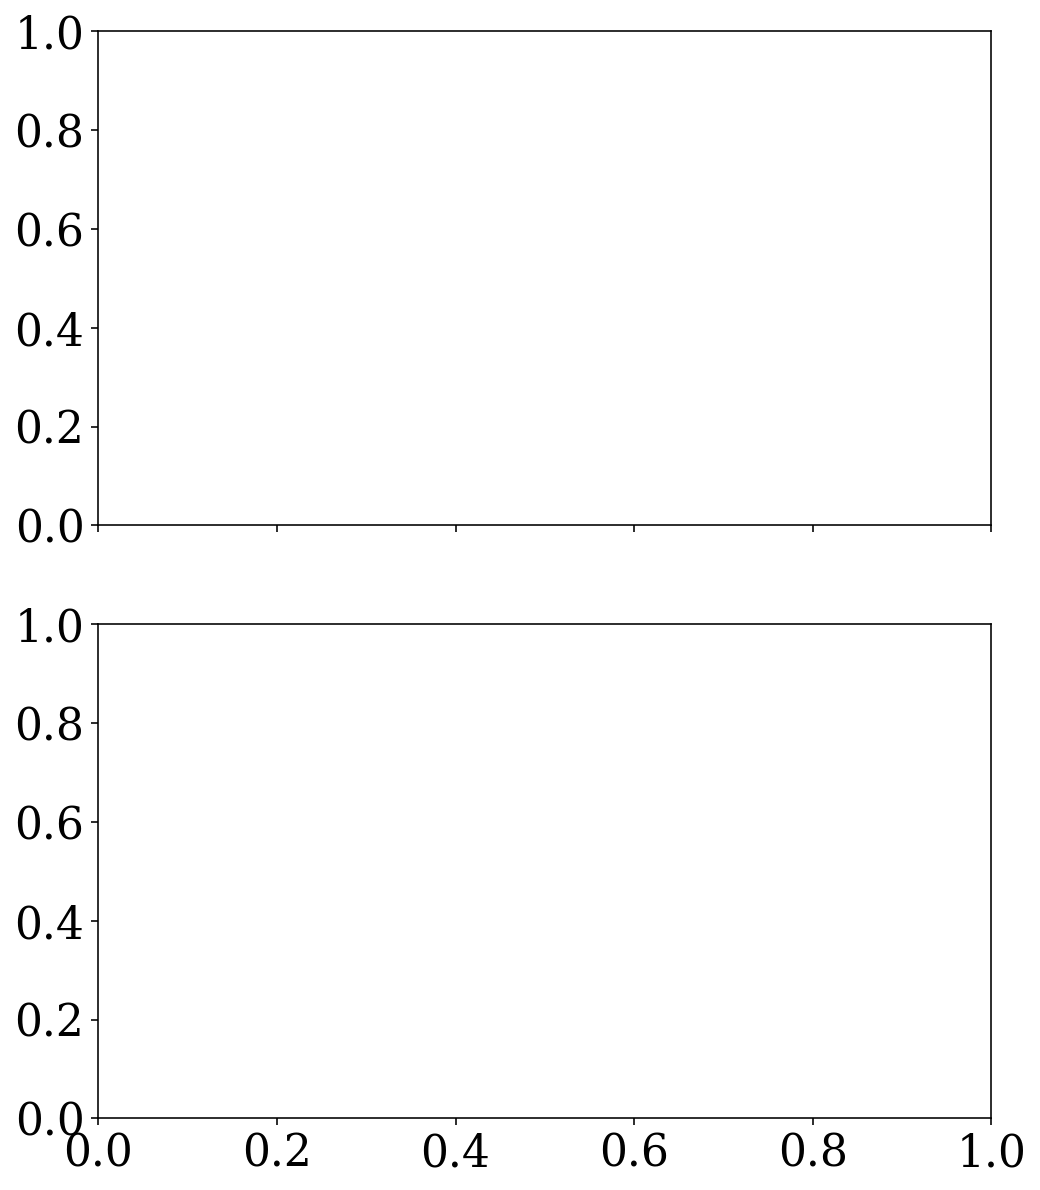

In [25]:
###Number of pulsars and their spin period and magnetic field distribution
###Separating single and binary MSPs
dpsr_mass = pd.read_excel('/projects/b1095/syr904/projects/isolated_MSP/gc_psr_mass.xlsx',
                    names = ['psr_name','mp_med','mp_lsig','mp_usig','mc','mtot', 'pspin'])
mobs = np.array(dpsr_mass['mp_med'])
mobs_lsig = np.array(dpsr_mass['mp_lsig']); mobs_usig = np.array(dpsr_mass['mp_usig'])
print(mobs, mobs[mobs_lsig!=-100], mobs[mobs_lsig==-100])
Ps = np.array(dpsr_mass['pspin'])

N_allpsr = [[],[]]; N_msp = [[],[]]; N_ns = []
N_msp_lmcom = []
Ma_12Gyr = []; Mb_12Gyr = []

id_massive_12 = []; model_massive_12 = []; m_massive_12 = []

id_sin_nontde_nonwdwd = []; n_sin_nontde_nonwdwd = []
id_sin_nontde_nonwdwd_12Gyr = []
t_sin_nontde_nonwdwd_12Gyr = []

fig, axs = plt.subplots(nrows = 2, figsize=(8,10), sharex=True)
for xx in range(len(paths)):
    t_conv = dyn.conv('t', paths[xx]+'initial.conv.sh')
    
    psrfile = paths[xx]+'initial.morepulsars.dat'
    
    mall = []
    Bsin = []; Psin = []; msin = []
    Bbin = []; Pbin = []; mbin = []; mcomp = []; kcomp = []
    thetime = [11000.,14000.]
    timestep_old=14000.
    npsr_sin = []; npsr_bin = []
    nmsp_sin = []; nmsp_bin = []
    nns = []
    nlbh = []
    nlmcomp = []
    
    n_wdwd = [0,0]; n_psrtde_msp = [0,0]; n_nstde_msp = [0,0]
    
    id_massive = []; model_massive = []; m_massive = []
    
    id_sins = []; t_sins = []
    
    id_sin_nontde_nonwdwd.append([]); n_timestep = 0
    
    with open(psrfile, 'r') as fpsr:
        next(fpsr)
        for line in fpsr:
            data = line.split()
            if float(data[1])*t_conv > thetime[1]:
                break
            if float(data[1])*t_conv < thetime[0]:
                continue
            
            timestep = float(data[1])*t_conv
            if timestep>timestep_old:
                n_timestep+=1
                
                if timestep_old<=12000. and timestep>12000.:
                    if xx<=ab_cut:
                        Ma_12Gyr = Ma_12Gyr + mall
                    else:
                        Mb_12Gyr = Mb_12Gyr + mall
                    
                    model_massive_12 = model_massive_12+model_massive
                    id_massive_12 = id_massive_12+id_massive
                    m_massive_12 = m_massive_12+m_massive
                    t_sin_nontde_nonwdwd_12Gyr.append(np.array(t_sins)[np.array(id_sins)!=0])
                    id_sin_nontde_nonwdwd_12Gyr.append(np.array(id_sins)[np.array(id_sins)!=0])
                    
                        
                Psin = np.array(Psin)
                Pbin = np.array(Pbin)
                mall = np.array(mall)
                mcomp = np.array(mcomp); kcomp = np.array(kcomp)
                npsr_sin.append(len(Psin)-n_wdwd[0]+n_nstde_msp[0])
                npsr_bin.append(len(Pbin)-n_wdwd[1]+n_nstde_msp[1])
                nmsp_sin.append(len(Psin[Psin<=0.03])+n_psrtde_msp[0]+n_nstde_msp[0])
                nmsp_bin.append(len(Pbin[Pbin<=0.03])+n_psrtde_msp[1]+n_nstde_msp[1])
                nlmcomp.append(len(mcomp[(mcomp<=0.01) & (kcomp>10)]))
                nns.append(len(mall))
                nlbh.append(len(mall[mall>2.5]))
                
                        
                mall = []
                Bsin = []; Psin = []; msin = []
                Bbin = []; Pbin = []; mbin = []; mcomp = []; kcomp = []
                
                n_wdwd = [0,0]; n_psrtde_msp = [0,0]; n_nstde_msp = [0,0]
                    
                id_massive = []; model_massive = []; m_massive = []
                
                #if xx==6:
                #    print(id_sins, t_sins)
                id_sins = []; t_sins = []
     
                
            if int(data[2])!=1:
                mall.append(float(data[5]))
                if float(data[5])>1.5:
                    model_massive.append(xx); id_massive.append(float(data[3]))
                    m_massive.append(float(data[5]))
                    
                if float(data[7])>=float(data[9])**2*(0.17*10**12):
                    Bsin.append(float(data[7]))
                    Psin.append(float(data[9]))
                    msin.append(float(data[5]))
                    
                    if float(data[9])>0.03 and int(data[3]) in idtde_msp_all[xx]:
                        n_psrtde_msp[0]+=1
                        
                    if float(data[9])>0.03 and (int(data[3]) in id_wdwdcol_all[xx] or 
                                               int(data[3]) in id_wdwdmer_all[xx]):
                        n_wdwd[0]+=1
                        
                    if float(data[9])<=0.03 and (int(data[3]) not in idtde_msp_all[xx] and 
                       int(data[3]) not in id_wdwdcol_all[xx] and int(data[3]) not in id_wdwdmer_all[xx]):
                        id_sin_nontde_nonwdwd[xx].append(int(data[3]))
                        id_sins.append(int(data[3])); t_sins.append(timestep)
                else:
                    if int(data[3]) in idtde_msp_all[xx]:
                        n_nstde_msp[0]+=1
                        
            else:
                if int(data[11])==13:
                    mall.append(float(data[5]))
                    
                    if float(data[5])>1.5:
                        model_massive.append(xx); id_massive.append(float(data[3]))
                        m_massive.append(float(data[5]))
                    
                if int(data[11])==13 and float(data[7])>=float(data[9])**2*(0.17*10**12):
                    Bbin.append(float(data[7]))
                    Pbin.append(float(data[9]))
                    mbin.append(float(data[5]))
                    mcomp.append(float(data[6]))
                    kcomp.append(int(data[12]))
                    
                    
                    if float(data[9])>0.03 and int(data[3]) in idtde_msp_all[xx]:
                        n_psrtde_msp[1]+=1
                        
                    if float(data[9])>0.03 and (int(data[3]) in id_wdwdcol_all[xx] or 
                                               int(data[3]) in id_wdwdmer_all[xx]):
                        n_wdwd[1]+=1
                elif int(data[11])==13 and float(data[7])<float(data[9])**2*(0.17*10**12):
                    if int(data[3]) in idtde_msp_all[xx]:
                        n_nstde_msp[1]+=1
                        mcomp.append(float(data[6]))
                        kcomp.append(int(data[12]))
                
                if int(data[12])==13:
                    mall.append(float(data[6]))
                    
                    if float(data[6])>1.5:
                        model_massive.append(xx); id_massive.append(float(data[4]))
                        m_massive.append(float(data[6]))
                        
                if int(data[12])==13 and float(data[8])>=float(data[10])**2*(0.17*10**12):
                    Bbin.append(float(data[8]))
                    Pbin.append(float(data[10]))
                    mbin.append(float(data[6]))
                    mcomp.append(float(data[5]))
                    kcomp.append(int(data[11]))
                    
                    if float(data[10])>0.03 and int(data[4]) in idtde_msp_all[xx]:
                        n_psrtde_msp[1]+=1
                        
                    if float(data[10])>0.03 and (int(data[4]) in id_wdwdcol_all[xx] or 
                                               int(data[4]) in id_wdwdmer_all[xx]):
                        n_wdwd[1]+=1
                elif int(data[12])==13 and float(data[8])<float(data[10])**2*(0.17*10**12):
                    if int(data[4]) in idtde_msp_all[xx]:
                        n_nstde_msp[1]+=1
                        mcomp.append(float(data[5]))
                        kcomp.append(int(data[11]))
            
            timestep_old = timestep
    
    #print('allpsr:', model_label[xx], np.mean(npsr_sin), np.mean(npsr_bin))
    #print('msp:', model_label[xx], np.mean(nmsp_sin), np.mean(nmsp_bin))
    
    #print('Nns:', model_label[xx], np.mean(nns))
    #print('low-mass bh?', model_label[xx], np.mean(nlbh))
    #print('low-mass companion', model_label[xx], np.mean(nlmcomp))
        
    N_allpsr[0].append(np.mean(npsr_sin)); N_allpsr[1].append(np.mean(npsr_bin))
    N_msp[0].append(np.mean(nmsp_sin)); N_msp[1].append(np.mean(nmsp_bin))
    N_ns.append(np.mean(nns))
    N_msp_lmcom.append(np.mean(nlmcomp))
    
    n_sin_nontde_nonwdwd.append(len(np.array(id_sin_nontde_nonwdwd[xx])[np.array(id_sin_nontde_nonwdwd[xx])!=0])/
                                float(n_timestep+1))
    id_sin_nontde_nonwdwd[xx] = list(Counter(id_sin_nontde_nonwdwd[xx]).keys())
    
print('sin MSP ids', id_sin_nontde_nonwdwd)
#print('sin MSP 13 Gyr ids', id_sin_nontde_nonwdwd_13Gyr, t_sin_nontde_nonwdwd_13Gyr)
#np.savetxt('/projects/b1095/syr904/projects/isolated_MSP/massive_NS.dat', 
#           np.c_[model_massive_12,id_massive_12,m_massive_12],
#          fmt = '%d %d %f', header = '1.model 2.id 3.NS_mass[MSUN]', comments = '#', delimiter = '')

print(len(Ma_12Gyr), len(np.array(Ma_12Gyr)[np.array(Ma_12Gyr)>1.5])) 
print(len(Mb_12Gyr), len(np.array(Mb_12Gyr)[np.array(Mb_12Gyr)>1.5]))    
axs[0].hist(Ma_12Gyr, bins=15,
         histtype='step', alpha=0.6, color = 'b', lw=3)
axs[0].hist(Mb_12Gyr, bins=15,
         histtype='step', alpha=0.6, color = 'orange', lw=3)
axs[1].errorbar(mobs[mobs_lsig!=-100], 
             Ps[mobs_lsig!=-100], 
             xerr = [mobs_lsig[mobs_lsig!=-100], mobs_usig[mobs_lsig!=-100]], 
             marker='o', markersize=4, linestyle='none',markeredgewidth=2,
             capsize=0, color = 'k', alpha=0.5, label = 'Observations')
axs[1].errorbar(mobs[mobs_lsig==-100], 
             Ps[mobs_lsig==-100], 
             xuplims = True, xerr=0.05,
             marker='o', markersize=4, linestyle='none',markeredgewidth=2,
             color = 'k', alpha=0.5)


axs[0].xaxis.set_minor_locator(AutoMinorLocator())
axs[0].set_ylabel(r'$N$')
axs[0].set_yscale('log')
axs[1].set_ylabel(r'$P$ [ms]')
axs[1].set_yscale('log')
axs[1].set_xlabel(r'$M_{\rm{NS}}\,[M_{\odot}]$')
axs[1].legend(loc='upper right', fontsize=18)
fig.tight_layout()

#plt.savefig(savepath+'ns_mass_all_12Gyr.pdf', dpi=300)

data_sin_msp = [n_sin_nontde_nonwdwd, N_msp_lmcom, list(np.array(N_msp_lmcom)+np.array(n_sin_nontde_nonwdwd))]
pd.DataFrame(data_sin_msp)
#print('number of single MSPs', N_msp_lmcom, n_sin_nontde_nonwdwd, np.array(N_msp_lmcom)+np.array(n_sin_nontde_nonwdwd))

In [14]:
###### Save the arrays into a file
np.savetxt(savepath+'table.dat', np.c_[Mclu, N_bh, N_ns, N_wdwdcoll_tot, N_wdwdmer_tot, N_tde, 
                                       np.array(N_allpsr[0])+np.array(N_allpsr[1]), 
                                       N_BBH, N_DNS, N_NSBH, N_BHWD, N_NSWD, N_DWD],
          fmt = '%f %f %f %f %f %f %f %f %f %f %f %f %f',
          header = '1.Mclu 2.Nbh 3.Nns 4.Nwdcolltot 5.Nwdmertot 6.Ntde 7.Nallpsr 8.NBBH 9.NBNS 10.NBHNS 11.NBHWD 12.NNSWD 13.NDWD',
          delimiter = ' ')
#data_table = np.genfromtxt(savepath+'table.dat')
#np.savetxt(savepath+'table.dat', np.c_[data_table[:,0],data_table[:,1],data_table[:,2],data_table[:,3],
#              data_table[:,4],data_table[:,5],data_table[:,6],data_table[:,7],data_table[:,8],
#              data_table[:,9],data_table[:,10],N_ns_wdwdmer[0],N_ns_wdwdmer[1]],
#          fmt = '%f %f %f %f %f %f %f %f %f %f %f %f %f',
#          header = '1.Mclu 2.Nbh 3.Nns 4.Nwdcolltot 5.Ntde 6.Nallpsr_sin 7.Nallpsr_bin 8.Nmsp_sin 9.Nmsp_bin 10.Nnscoll_sin 11.Nnscoll_bin 12.Nnsmer_sin 13.Nnsmer_bin',
#          delimiter = ' ')

data_table = np.genfromtxt(savepath+'table.dat')
f=open(savepath+'latex_table.txt', 'w+')
for ii in range(len(paths)):
    f.write('%s & %.2f & %d & %d & %d & %d & %d & %d & %d & %d\\\\\n'
            %(ii+1, 
              data_table[:,0][ii]/1.e5, np.round(data_table[:,1][ii]),
              np.round(data_table[:,2][ii]), np.round(data_table[:,7][ii]),
              np.round(data_table[:,8][ii]),np.round(data_table[:,9][ii]),
              np.round(data_table[:,10][ii]),np.round(data_table[:,11][ii]),np.round(data_table[:,12][ii])))

f.close()

In [24]:
###BH binaries at the present day
for xx in range(len(paths)):
    t_conv = dyn.conv('t', paths[xx]+'initial.conv.sh')
    
    all_bhsnaps_float, all_bhsnaps_str = bh_snaps(paths[xx])
    all_bhsnaps_float = all_bhsnaps_float*t_conv
    
    for ii in range(len(all_bhsnaps_float)):
        #i all_bhsnaps_float[ii]<11000. or all_bhsnaps_float[ii]>14000.:
        #   continue
            
        if all_bhsnaps_float[ii]<11900.:
            continue
        
        bh_h5 = cmct.Snapshot(fname=paths[xx]+'initial.blackhole.snapshots.h5', 
                                    snapshot_name='/t='+all_bhsnaps_str[ii], 
                                    conv=paths[xx]+'initial.conv.sh', 
                                    dist=4.125, # distance to cluster in kpc
                                    z=0.0002)
        print(bh_h5.age)
        binflag = np.array(bh_h5.data['binflag'])
        m = np.array(bh_h5.data['m_MSUN'])[binflag!=1]
        k0 = np.array(bh_h5.data['bin_startype0'])[binflag==1]; k1 = np.array(bh_h5.data['bin_startype1'])[binflag==1]
        m0 = np.array(bh_h5.data['m0_MSUN'])[binflag==1]; m1 = np.array(bh_h5.data['m1_MSUN'])[binflag==1]
        radrol0 = np.array(bh_h5.data['radrol0'])[binflag==1]; radrol1 = np.array(bh_h5.data['radrol1'])[binflag==1], 
        print(len(binflag[binflag==1]), k0, k1, radrol0, radrol1)
        
        break
        

11.9499418746
1 [14] [12] [1.93121775e-06] (array([0.00067175]),)
11.912282428400001
1 [14] [13] [5.32126343e-05] (array([3.46821484e-05]),)
12.00868534692
5 [14 12 11 12 12] [13 14 14 14 14] [7.02962339e-06 9.17356640e-03 2.61783611e-03 4.46757354e-03
 1.91237273e-04] (array([8.93809158e-06, 2.70724160e-05, 2.43799454e-06, 4.03429765e-05,
       7.37275703e-07]),)
11.942262870239999
1 [12] [14] [0.00088589] (array([3.62227564e-06]),)
12.0382750564
1 [11] [14] [1.03643853] (array([1.83747009e-05]),)
11.903236873039999
0 [] [] [] (array([], dtype=float64),)
11.951894861560001
4 [11 11  0 13] [14 14 14 14] [1.11895303e+00 1.03662721e+00 1.00062010e+00 3.41451468e-08] (array([1.16134413e-05, 1.85240002e-05, 1.12026439e-05, 2.15321951e-08]),)
11.95315951172
2 [14 12] [14 14] [1.00000000e-04 1.02976405e-03] (array([1.00000000e-20, 4.04918514e-06]),)
11.987143104440001
4 [14 11 14 11] [11 14 13 14] [3.50655040e-06 7.98494355e-03 1.97394404e-05 5.12057551e-03] (array([4.24340725e-03, 9.132366